<a href="https://colab.research.google.com/github/saiashwinkumar/DBA5101-demand-analysis/blob/main/DBA5101_demand_analysis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***DBA5101 Project 1: Train Demand Function***
#### **Team Members (Group 26):**
(1) Erica Chi Yi Tung (Student ID: A0318639R)

(2) Hrithik Kannan Krishnan (Student ID: A0318899B)

(3) Om Sanjay Gorakhia (Student ID: A0318038E)

(4) Priyanshi Verma (Student ID: A0318672X)

(5) Sai Ashwin Kumar Chandramouli (Student ID: A0329294U)


---

### ***Preliminary Analysis***
---



In [ ]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy import stats
from scipy.stats import shapiro, normaltest
from linearmodels.iv import IV2SLS

In [ ]:
data = pd.read_csv('Data-GP1.csv')

In [ ]:
df = pd.DataFrame(data)
print(df)

        num_seats_total  mean_net_ticket_price Dept_Date Purchase_Date  \
0                     1             188.663422   10/9/19      10/10/18   
1                     1             358.428869   5/27/19        6/6/18   
2                     1             356.372684   5/31/20       6/17/19   
3                     1             396.370505  12/10/19      12/27/18   
4                     1             364.264552   5/31/20       6/19/19   
...                 ...                    ...       ...           ...   
209692                4             468.650069   3/26/19       3/26/19   
209693                1             468.659177  12/21/18      12/21/18   
209694                1             668.061946    6/9/19        6/9/19   
209695                2             381.438513   1/17/19       1/17/19   
209696                3             546.201649   6/25/18       6/25/18   

       Train_Number_All  Culmulative_sales  isNormCabin  isReturn  isOneway  \
0                     A         

In [ ]:
print(df.head())

   num_seats_total  mean_net_ticket_price Dept_Date Purchase_Date  \
0                1             188.663422   10/9/19      10/10/18   
1                1             358.428869   5/27/19        6/6/18   
2                1             356.372684   5/31/20       6/17/19   
3                1             396.370505  12/10/19      12/27/18   
4                1             364.264552   5/31/20       6/19/19   

  Train_Number_All  Culmulative_sales  isNormCabin  isReturn  isOneway  \
0                A                  1            1         0         0   
1                B                  1            0         1         0   
2                B                  1            0         1         0   
3                C                  1            0         1         0   
4                B                  2            0         1         0   

  Customer_Cat  
0            A  
1            A  
2            A  
3            A  
4            A  


In [ ]:
df.dtypes

,0
num_seats_total,int64
mean_net_ticket_price,float64
Dept_Date,object
Purchase_Date,object
Train_Number_All,object
Culmulative_sales,int64
isNormCabin,int64
isReturn,int64
isOneway,int64
Customer_Cat,object


In [ ]:
df.isna().sum()

,0
num_seats_total,0
mean_net_ticket_price,0
Dept_Date,0
Purchase_Date,0
Train_Number_All,0
Culmulative_sales,0
isNormCabin,0
isReturn,0
isOneway,0
Customer_Cat,0


In [ ]:
df.describe()

,num_seats_total,mean_net_ticket_price,Culmulative_sales,isNormCabin,isReturn,isOneway
count,209697.000000,209697.000000,209697.000000,209697.000000,209697.000000,209697.000000
mean,2.383019,230.116900,15.875063,0.598249,0.480183,0.122873
std,2.083324,147.024784,19.795677,0.490253,0.499608,0.328292
min,1.000000,1.278969,1.000000,0.000000,0.000000,0.000000
25%,1.000000,108.870193,3.000000,0.000000,0.000000,0.000000
50%,2.000000,186.282199,8.000000,1.000000,0.000000,0.000000
75%,3.000000,350.409481,21.000000,1.000000,1.000000,0.000000
max,66.000000,7855.766106,187.000000,1.000000,1.000000,1.000000


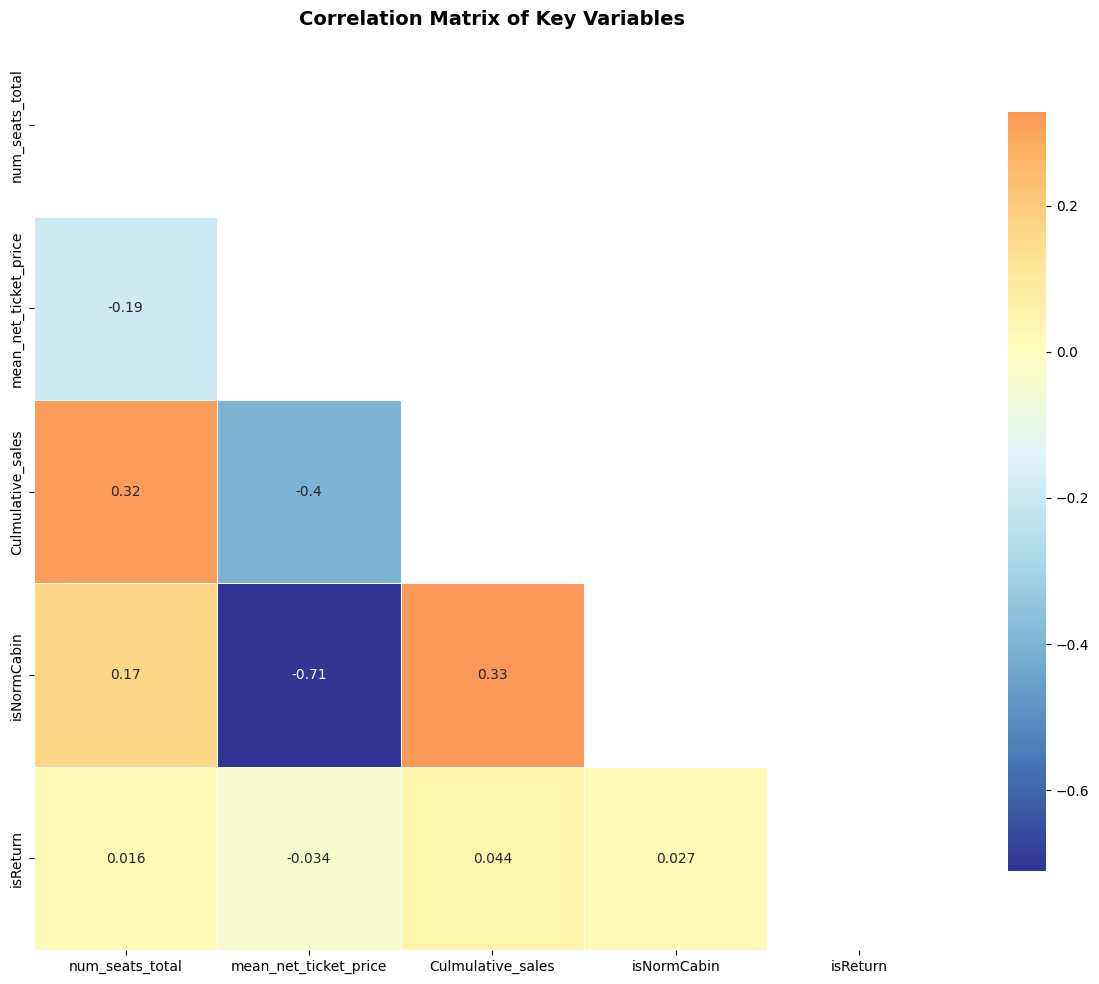

In [ ]:
#Using only numeric columns for correlation matrix
numeric_cols = ['num_seats_total', 'mean_net_ticket_price', 'days_advance',
                   'Culmulative_sales', 'isNormCabin', 'isReturn', 'Customer_Cat_B']
available_cols = [col for col in numeric_cols if col in df.columns]

if len(available_cols) > 2:
  plt.figure(figsize=(12, 10))
  correlation_matrix = df[available_cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Key Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
#Changing date variables to datetime format
df["Dept_Date"] = pd.to_datetime(df['Dept_Date'])
df["Purchase_Date"] = pd.to_datetime(df["Purchase_Date"])

In [ ]:
#Creation of new variable `days_to_departure` using `Dept_Date` and `Purchase_Date`
df["days_to_departure"] = (df["Dept_Date"] - df["Purchase_Date"]).dt.days

In [ ]:
corrs = df[['mean_net_ticket_price','num_seats_total','days_to_departure',
            'Culmulative_sales','isNormCabin','isReturn','isOneway']].corr()

print(corrs['mean_net_ticket_price'].sort_values(ascending=False))

mean_net_ticket_price    1.000000
isOneway                 0.139430
isReturn                -0.033576
num_seats_total         -0.193212
Culmulative_sales       -0.403455
days_to_departure       -0.509924
isNormCabin             -0.711240
Name: mean_net_ticket_price, dtype: float64


In [ ]:
#Creating log variables to run log-linear model
df["log_seats"] = np.log(df["num_seats_total"])
df["log_price"] = np.log(df["mean_net_ticket_price"])

In [ ]:
#Creation of new variable `trip_type` to categorize the type of ticket (trip)
df['trip_type'] = df['isReturn'].apply(lambda x: 1 if x == 1 else 0)

In [ ]:
df['trip_type'] = np.select(
    [df['isOneway'].eq(1), df['isReturn'].eq(1)],
    ['Oneway','Return'],
    default='Neither')

In [ ]:
df['demand_intensity'] = df['num_seats_total'] / df['Culmulative_sales']

In [ ]:
#Quick random sample
# import numpy as np, pandas as pd, gc

# BASE = df if 'df' in globals() else data  # whichever you're using
# N_SAMPLE = 30000                         # tweak as needed
# SEED = 42

# df_dev = BASE.sample(n=min(N_SAMPLE, len(BASE)), random_state=SEED).copy()

# # Light memory trim
# for c in ['trip_type','CabinType','Customer_Cat']:
#    if c in df_dev.columns:
#        df_dev[c] = df_dev[c].astype('category')
# gc.collect()

# print(f"Dev sample rows: {len(df_dev):,}")
# # IMPORTANT: Recompute iv_price_loo on this sample later (will be weaker than full data).
# # From here on, run your models using: df = df_dev
# df = df_dev


Our empirical strategy is designed to estimate the causal effect of key independent variables, such as price, on the
dependent variable of interest, quantity demanded, while systematically addressing potential concerns related to
endogeneity, unobserved heterogeneity, and non-linearities. The analysis adopts a sequential modeling framework,
beginning with baseline specifications and progressively incorporating refinements to enhance robustness and
interpretability.

### ***OLS + Log-Log Models***
---

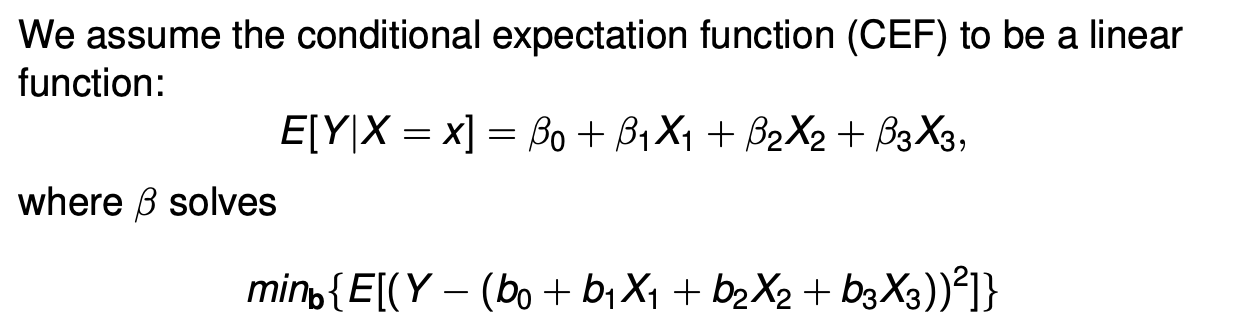

In [ ]:
formula = "num_seats_total ~ mean_net_ticket_price + days_to_departure + isNormCabin + isReturn + isOneway + Train_Number_All + Customer_Cat"

In [ ]:
ols_model0 =smf.ols(formula=formula, data=df).fit(cov_types="HC0")
print(ols_model0.summary())

                            OLS Regression Results                            
Dep. Variable:        num_seats_total   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     973.2
Date:                Sat, 20 Sep 2025   Prob (F-statistic):               0.00
Time:                        05:21:42   Log-Likelihood:            -4.4215e+05
No. Observations:              209697   AIC:                         8.843e+05
Df Residuals:                  209676   BIC:                         8.846e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.42

In [ ]:
ols_model1 =smf.ols(formula=formula, data=df).fit(cov_types="HC1")
print(ols_model1.summary())

                            OLS Regression Results                            
Dep. Variable:        num_seats_total   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     973.2
Date:                Sat, 20 Sep 2025   Prob (F-statistic):               0.00
Time:                        05:21:46   Log-Likelihood:            -4.4215e+05
No. Observations:              209697   AIC:                         8.843e+05
Df Residuals:                  209676   BIC:                         8.846e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.42

In [ ]:
ols_model2 =smf.ols(formula=formula, data=df).fit(cov_types="HC2")
print(ols_model2.summary())

                            OLS Regression Results                            
Dep. Variable:        num_seats_total   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     973.2
Date:                Sat, 20 Sep 2025   Prob (F-statistic):               0.00
Time:                        05:21:54   Log-Likelihood:            -4.4215e+05
No. Observations:              209697   AIC:                         8.843e+05
Df Residuals:                  209676   BIC:                         8.846e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.42

In [ ]:
ols_model3 =smf.ols(formula=formula, data=df).fit(cov_types="HC3")
print(ols_model3.summary())

                            OLS Regression Results                            
Dep. Variable:        num_seats_total   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     973.2
Date:                Sat, 20 Sep 2025   Prob (F-statistic):               0.00
Time:                        05:21:59   Log-Likelihood:            -4.4215e+05
No. Observations:              209697   AIC:                         8.843e+05
Df Residuals:                  209676   BIC:                         8.846e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.42

Big n, mild leverage: HC1 is a safe, common default.

Small/medium n or noticeable leverage: HC3.

Very small n / extreme leverage: consider HC4/HC4m/HC5.

Panel/clustered data: use cluster-robust (cov_type="cluster") instead, since HC* only handles heteroskedasticity, not within-cluster correlation.

All four types of adjustments for heteroskedasticity illustrate no change/difference from one another due to the large sample size included in the data. HC0, HC1, HC2, and HC3 all converge to the same thing as 𝑛 → ∞, producing consistent results across the specifications.
In this case, choosing HC1 would be be best as it is most commonly used for larger sample sizes. If we want our model to be more conservative, we could pick HC3 as it tends to be more robust with smaller sample sizes, however, since our sample size is relatively large, HC1 would be the better option.

While OLS provides an initial assessment of correlations, it is
susceptible to omitted variable bias and measurement error, which may produce inconsistent estimates. To account for
potential non-linearities and elasticity-based interpretations, we subsequently implement a log-log transformation,
enhancing both interpretability and model fit.

In [ ]:
formula_log = "log_seats ~ log_price + np.log(days_to_departure + 1) + isNormCabin + isReturn + isOneway + Train_Number_All + Customer_Cat"

In [ ]:
log_model1 = smf.ols(formula=formula_log, data=df).fit(cov_type="HC1")
print(log_model1.summary())

                            OLS Regression Results                            
Dep. Variable:              log_seats   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Sat, 20 Sep 2025   Prob (F-statistic):               0.00
Time:                        05:22:05   Log-Likelihood:            -1.9669e+05
No. Observations:              209697   AIC:                         3.934e+05
Df Residuals:                  209676   BIC:                         3.936e+05
Df Model:                          20                                         
Covariance Type:                  HC1                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Why run Log-Log?
*   interprets in percentage change
*   some of the data was heavily right-skewed so to mitigate heteroskedasticity we created a log-linear relationship (price and seats)
*   relationship with `num_seats_total` is not linear as it can increase/decrease drastically, therefore we logged the data

To mitigate potential endogeneity concerns, we employed an Instrumental Variables (IV) approach
estimated through Two-Stage Least Squares (2SLS). This approach helps correct for biases that may arise from
simultaneity between price and demand, yielding more consistent estimates of the demand function. Our methodology
follows these steps:

• First Stage: Regress the endogenous regressor on chosen instruments and control variables to isolate the
exogenous variation.

• Second Stage: Use the predicted values from the first stage in the outcome regression to obtain consistent
estimates of causal effects.

### ***2 Stage Least Squares (2SLS) Model***
  Instrument Variable (IV): leave-one-out mean price within the same train + month (`iv_price_loo`)

We first decided to run the regression with price to see what correlates with price the most. We then used this model to help predict the regular 2SLS that then regresses the dependent variables against num_seats_total

The second stage of 2SLS is using the IV to see if it improves prediction accuracy.

---

In [ ]:
from linearmodels.iv import IV2SLS
import pandas as pd, numpy as np

Explicitly regress price on all other observables to see which variables the pricing algorithm responds to:

In [ ]:
#required
import pandas as pd
import statsmodels.formula.api as smf

# 1) Ensure datetime & create YM as string (not Period)
# if df['Dept_Date'].dtype != 'datetime64[ns]':
#     df['Dept_Date'] = pd.to_datetime(df['Dept_Date'], errors='coerce')

df['ym'] = df['Dept_Date'].dt.to_period('M').astype(str)  # e.g., '2019-07'

# 2) Optional: cast to category for memory/speed (not required)
for c in ['ym', 'Train_Number_All', 'Customer_Cat']:
    df[c] = df[c].astype('category')

# 3) First-stage style PRICE regression with YM and Train FE
# Note: keep your column name exactly as in the data: 'Culmulative_sales'
formula = (
    "mean_net_ticket_price ~ days_to_departure + Culmulative_sales "
    "+ C(isNormCabin) + C(isReturn) + C(isOneway) + C(Customer_Cat) "
    "+ C(Train_Number_All) + C(ym)"
)

m_price = smf.ols(formula, data=df).fit(
    cov_type="cluster",
    cov_kwds={"groups": df["Train_Number_All"]}  # cluster by route/train
)

print(m_price.summary())


                              OLS Regression Results                             
Dep. Variable:     mean_net_ticket_price   R-squared:                       0.648
Model:                               OLS   Adj. R-squared:                  0.648
Method:                    Least Squares   F-statistic:                     518.4
Date:                   Sat, 20 Sep 2025   Prob (F-statistic):           1.92e-16
Time:                           05:22:11   Log-Likelihood:            -1.2347e+06
No. Observations:                 209697   AIC:                         2.469e+06
Df Residuals:                     209652   BIC:                         2.470e+06
Df Model:                             44                                         
Covariance Type:                 cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

Now we want to check what are the other direct variables and derived variables that may not affect the price but may affect the seats demanded:

This is a code block that,

1.   Builds ym and Trip_Type,
2.   Fits two FE models:

  * Price model: what predicts mean_net_ticket_price
  * Seats model (conditional on price): what predicts num_seats_total

3.   Runs per-term Wald tests and returns a table showing which variables look like direct demand shifters (significant for seats but NOT for price).

In [ ]:
#required
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# =========================
# CONFIG
# =========================
SAMPLE_N = 30000   # reduce to 20k/10k if memory is tight
SEED     = 42
ALPHA_SEATS  = 0.05   # significance to call "affects seats"
ALPHA_PRICE  = 0.10   # insignificance threshold to call "does NOT affect price"

# =========================
# PREP
# =========================
dfc = df.copy()

# Ensure datetimes + Year–Month FE as string
# if dfc['Dept_Date'].dtype != 'datetime64[ns]':
#     dfc['Dept_Date'] = pd.to_datetime(dfc['Dept_Date'], errors='coerce')
# dfc['ym'] = dfc['Dept_Date'].dt.to_period('M').astype(str)

# Trip_Type (if you haven't created it already)
# if 'Trip_Type' not in dfc.columns:
#     dfc['Trip_Type'] = np.select(
#         [
#             (dfc['isOneway']==1) & (dfc['isReturn']==0),
#             (dfc['isOneway']==0) & (dfc['isReturn']==1),
#             (dfc['isOneway']==1) & (dfc['isReturn']==1),
#             (dfc['isOneway']==0) & (dfc['isReturn']==0),
#         ],
#         ['One-way Only','Return Only','Both','Neither'],
#         default='Unknown'
#     )

# Categorical casting (helps memory & formula terms)
for c in ['Customer_Cat','Train_Number_All','ym','trip_type']:
    dfc[c] = dfc[c].astype('category')

# Optional downsample for fitting stability/RAM
if len(dfc) > SAMPLE_N:
    dfc = dfc.sample(n=SAMPLE_N, random_state=SEED)

# =========================
# MODELS
# =========================
# --- PRICE model (reduced form): what moves price (supply side) ---
price_formula = (
    "mean_net_ticket_price ~ days_to_departure "
    "+ C(trip_type, Treatment('Oneway')) "
    "+ C(isNormCabin) + C(isReturn) + C(isOneway) + C(Customer_Cat)"
    " + C(Train_Number_All) + C(ym)"
)

m_price = smf.ols(price_formula, data=dfc).fit(
    cov_type="cluster",
    cov_kwds={"groups": dfc["Train_Number_All"]}
)

# --- SEATS model (demand), conditional on price ---
# Include price so we detect variables that shift seats *holding price fixed*
seats_formula = (
    "num_seats_total ~ mean_net_ticket_price + days_to_departure + Culmulative_sales "
    "+ C(trip_type, Treatment('Oneway')) "
    "+ C(isNormCabin) + C(isReturn) + C(isOneway) + C(Customer_Cat)"
    " + C(Train_Number_All) + C(ym)"
)

m_seats = smf.ols(seats_formula, data=dfc).fit(
    cov_type="cluster",
    cov_kwds={"groups": dfc["Train_Number_All"]}
)

# =========================
# TERM-LEVEL WALT TESTS (per factor)
# =========================

def wald_terms_table(res):
    """
    Robustly extract per-term Wald p-values from statsmodels OLS/GLM results.
    Works with clustered/robust covariances (F or chi2), and across versions.
    Returns a DataFrame with columns: ['term','p_value'].
    """
    wt = res.wald_test_terms()

    # Try to get a tabular object
    table = getattr(wt, "table", None)
    df = None

    if table is not None:
        # Case A: Already a DataFrame
        if isinstance(table, pd.DataFrame):
            df = table.reset_index().rename(columns={"index": "term"})
        else:
            # Case B: SimpleTable-like (has .data)
            try:
                hdr  = table.data[0]
                body = table.data[1:]
                df = pd.DataFrame(body, columns=hdr)
                if "term" not in df.columns:
                    df = df.rename(columns={df.columns[0]: "term"})
            except Exception:
                df = None

    if df is not None:
        # Find the p-value column name robustly
        candidates = ["P>F", "P>chi2", "pvalue", "P>|t|", "Pr(>F)", "P-value"]
        pcol = next((c for c in candidates if c in df.columns), None)
        if pcol is None:
            # fallback: search any column that looks like a p-value
            pcol = next(
                (c for c in df.columns if "p>" in str(c).lower()
                 or "pval" in str(c).lower()
                 or "p-value" in str(c).lower()),
                None
            )
        if pcol is None:
            raise KeyError(f"No p-value column found in Wald table. Columns: {list(df.columns)}")
        out = df[["term", pcol]].rename(columns={pcol: "p_value"})
        # Drop intercept if present
        return out[out["term"].str.lower() != "intercept"].reset_index(drop=True)

    # ---- Fallback: build from arrays ----
    pvals = np.atleast_1d(getattr(wt, "pvalue", np.array([]))).astype(float)
    # Try to recover term names
    term_names = getattr(wt, "row_labels", None)
    if term_names is None:
        # Try design_info (may include intercept; filter later)
        try:
            term_names = list(res.model.data.design_info.term_names)
        except Exception:
            term_names = [f"term_{i}" for i in range(len(pvals))]
    out = pd.DataFrame({"term": term_names, "p_value": pvals})
    return out[out["term"].str.lower() != "intercept"].reset_index(drop=True)

price_terms = wald_terms_table(m_price).rename(columns={"p_value": "p_price"})
seats_terms = wald_terms_table(m_seats).rename(columns={"p_value": "p_seats"})

terms = price_terms.merge(seats_terms, on="term", how="outer")

# Heuristic classification:
def classify(row):
    p_price = row["p_price"]
    p_seats = row["p_seats"]
    if pd.notna(p_seats) and (p_seats < ALPHA_SEATS) and (pd.isna(p_price) or p_price >= ALPHA_PRICE):
        return "Direct demand shifter (seats↑/↓, not price)"
    if pd.notna(p_seats) and (p_seats < ALPHA_SEATS) and (pd.notna(p_price) and p_price < ALPHA_SEATS):
        return "Affects both price & seats (endogeneity risk)"
    if pd.notna(p_seats) and (p_seats >= ALPHA_PRICE) and (pd.notna(p_price) and p_price < ALPHA_SEATS):
        return "Supply-side (price) driver (good IV candidate)"
    return "Weak/insignificant in both"

terms["classification"] = terms.apply(classify, axis=1)

# Add simple effect direction for continuous vars (sign of coef)
cont_signs = {}
for name in ["mean_net_ticket_price","days_to_departure","Culmulative_sales"]:
    if name in m_seats.params.index:
        cont_signs[f"seats_sign:{name}"] = np.sign(m_seats.params[name])
    if name in m_price.params.index:
        cont_signs[f"price_sign:{name}"] = np.sign(m_price.params[name])

# Optional: attach top-level continuous signs as a note
terms = terms.assign(notes="")
for k, v in cont_signs.items():
    terms.loc[terms["term"].eq(k.split(":")[-1]), "notes"] = f"sign={int(v)}"

# Sort for readability
terms = terms.sort_values(["classification","term"]).reset_index(drop=True)

print("\n=== Per-term significance summary ===")
print(terms)

print("\n--- Model fit (price) ---")
print(f"R^2: {m_price.rsquared:.3f}  Adj.R^2: {m_price.rsquared_adj:.3f}")

print("\n--- Model fit (seats) ---")
print(f"R^2: {m_seats.rsquared:.3f}  Adj.R^2: {m_seats.rsquared_adj:.3f}")

# Optional: show top candidate direct demand shifters
cands = terms[terms["classification"].str.contains("Direct demand shifter")]
print("\nPotential direct demand shifters (significant for seats, not price):")
print(cands if not cands.empty else "None at chosen thresholds.")



=== Per-term significance summary ===
                                term                 p_price  \
0                    C(Customer_Cat)   6.134373246157896e-28   
1                C(Train_Number_All)                     0.0   
2                     C(isNormCabin)                     0.0   
3                        C(isOneway)  6.306090545168989e-274   
4                        C(isReturn)  0.00022065444595548546   
5  C(trip_type, Treatment('Oneway'))                     0.0   
6                              C(ym)                     0.0   
7                  days_to_departure  8.933810379594331e-123   
8                  Culmulative_sales                     NaN   
9              mean_net_ticket_price                     NaN   

                  p_seats                                 classification  \
0    9.86738105683607e-37  Affects both price & seats (endogeneity risk)   
1                     0.0  Affects both price & seats (endogeneity risk)   
2    0.007373012755430753  A

#### ***Simple IV-2SLS model***

Goal: find a price shifter that moves price but is not directly driven by each row’s own demand shock.

iv_price_loo = (sum_p − own_price) / (n_p − 1)

i.e., the average price of the other observations in the same train & month, excluding itself.

Intuition: the instrument uses “what others in your same train–month are charging” (excluding you) as a source of variation to help explain your price, while trying not to use your row’s own price directly.

**Outcome (demand):** num_seats_total (how many seats sold).

**Endogenous regressor:** mean_net_ticket_price (price can be correlated with demand shocks).

**Instrument:** iv_price_loo (the leave-one-out price).

**Controls:** demand_intensity, days_to_departure, and dummies for trip_type, CabinType, and Customer_Cat.

In [ ]:
# !pip -q install linearmodels
import numpy as np, pandas as pd
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# Using dff for intermediate steps to avoid confusion with original df
dff = df.copy()

# --- Build ym for IV GROUPING ONLY (not used as FE) ---
for c in ["Dept_Date","Purchase_Date"]:
    if c in dff.columns:
        dff[c] = pd.to_datetime(dff[c], errors="coerce")
if "ym" not in dff.columns:
    if "Dept_Date" in dff and dff["Dept_Date"].notna().any():
        dff["ym"] = dff["Dept_Date"].dt.to_period("M").astype(str)
    elif "Purchase_Date" in dff and dff["Purchase_Date"].notna().any():
        dff["ym"] = dff["Purchase_Date"].dt.to_period("M").astype(str)
    else:
        dff["ym"] = "NA"

# days_to_departure if needed
if "days_to_departure" not in dff.columns and {"Dept_Date","Purchase_Date"}.issubset(dff.columns):
    dff["days_to_departure"] = (dff["Dept_Date"] - dff["Purchase_Date"]).dt.days

# Trip/Cabin labels if needed
if "trip_type" not in dff.columns and {"isOneway","isReturn"}.issubset(dff.columns):
    dff["trip_type"] = np.select(
        [dff["isOneway"].eq(1), dff["isReturn"].eq(1)],
        ["Oneway","Return"],
        default="Neither"
    )
if "CabinType" not in dff.columns and "isNormCabin" in dff.columns:
    dff["CabinType"] = dff["isNormCabin"].map({0:"Special", 1:"Normal"})

# --- Leave-one-out IV within Train×Month ---
g = (dff.groupby(["Train_Number_All","ym"])["mean_net_ticket_price"]
        .agg(sum_p="sum", n_p="count").reset_index())
dff = dff.merge(g, on=["Train_Number_All","ym"], how="left")
dff["iv_price_loo"] = np.where(
    dff["n_p"]>1,
    (dff["sum_p"] - dff["mean_net_ticket_price"]) / (dff["n_p"] - 1),
    np.nan
)

# Clean IV sample
ivdf = dff[(dff["mean_net_ticket_price"]>0) &
           (dff["num_seats_total"]>=0) &
           (dff["days_to_departure"]>=0) &
           dff["iv_price_loo"].notna()].copy()

# --- Plain 2SLS (no YM-FE in the regression) ---
form_iv = (
    'num_seats_total ~ 1 + demand_intensity + days_to_departure '
    '+ C(trip_type, Treatment("Neither")) '
    '+ C(CabinType, Treatment("Special")) + C(Customer_Cat) '
    '+ [mean_net_ticket_price ~ iv_price_loo]'
)

iv_res = IV2SLS.from_formula(form_iv, data=ivdf).fit(cov_type='robust')
print(iv_res.summary)

# Cluster-robust by train (report this too)
iv_res_cl = IV2SLS.from_formula(form_iv, data=ivdf).fit(
    cov_type='clustered', clusters=ivdf['Train_Number_All']
)
print(iv_res_cl.summary)

# Optional: first-stage diagnostics
print("\nFirst stage:")
print(iv_res.first_stage.summary)  # includes Partial R² and F for the IV

# From here on, run your models using: df = dff (as per original comment intent)
df = dff

                          IV-2SLS Estimation Summary                          
Dep. Variable:        num_seats_total   R-squared:                      0.0532
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0532
No. Observations:              209690   F-statistic:                 2.097e+04
Date:                Sat, Sep 20 2025   P-value (F-stat)                0.0000
Time:                        05:22:14   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                                              Parameter Estimates                                               
                                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------------------
Intercept                    

#### ***IV-2SLS with Year-Month fixed effects (YM-FE)***

* Controls seasonality & shocks: YM-FE soak up monthwide demand/supply shocks (holidays, macro trends, fare rules) that move both price and seats → less omitted-variable bias than plain 2SLS.
* Cleaner IV variation: Using leave-one-out price within train×month while controlling for month FE ensures identification comes from within-month variation, not spurious month swings.
* Causal elasticity “within month”: The price coefficient (and elasticity) is interpreted holding constant the month, cabin, trip-leg type, customer segment, and booking horizon.

In [ ]:
dff = df.copy()

# ---------- 1) Build Year–Month label (ym) and days_to_departure ----------
for c in ["Dept_Date","Purchase_Date"]:
    if c in dff.columns:
        dff[c] = pd.to_datetime(dff[c], errors="coerce")

if "ym" not in dff.columns:
    if "Dept_Date" in dff and dff["Dept_Date"].notna().any():
        dff["ym"] = dff["Dept_Date"].dt.to_period("M").astype(str)     # 'YYYY-MM'
    elif "Purchase_Date" in dff and dff["Purchase_Date"].notna().any():
        dff["ym"] = dff["Purchase_Date"].dt.to_period("M").astype(str)
    else:
        raise ValueError("Need Dept_Date or Purchase_Date to construct ym.")

if "days_to_departure" not in dff.columns and {"Dept_Date","Purchase_Date"}.issubset(dff.columns):
    dff["days_to_departure"] = (dff["Dept_Date"] - dff["Purchase_Date"]).dt.days

# ---------- 2) Human-readable categoricals ----------
if "trip_type" not in dff.columns and {"isOneway","isReturn"}.issubset(dff.columns):
    dff["trip_type"] = np.select(
        [dff["isOneway"].eq(1), dff["isReturn"].eq(1)],
        ["Oneway","Return"],
        default="Neither"
    )
if "CabinType" not in dff.columns and "isNormCabin" in dff.columns:
    dff["CabinType"] = dff["isNormCabin"].map({0:"Special", 1:"Normal"})

# ---------- 3) Leave-one-out instrument within Train×Month (robust, no merge) ----------
grp = dff.groupby(["Train_Number_All","ym"])["mean_net_ticket_price"]
sum_tr = grp.transform("sum")
n_tr   = grp.transform("count")

# LOO: average of "other rows" within the same Train×YM
dff["iv_price_loo"] = np.where(
    n_tr > 1,
    (sum_tr - dff["mean_net_ticket_price"]) / (n_tr - 1),
    np.nan
)

# ---------- 4) Clean analysis sample ----------
need = ["num_seats_total","mean_net_ticket_price","days_to_departure",
        "trip_type","CabinType","Customer_Cat","Train_Number_All","ym","iv_price_loo"]

# include Culmulative_sales only if present
has_cum = "demand_intensity" in dff.columns
if has_cum:
    dff["demand_intensity"] = pd.to_numeric(dff["demand_intensity"], errors="coerce")
    need.append("demand_intensity")

ivdf = dff[need].copy()
ivdf = ivdf[
    (ivdf["mean_net_ticket_price"] > 0) &
    (ivdf["num_seats_total"]      >= 0) &
    (ivdf["days_to_departure"]    >= 0) &
    (ivdf["iv_price_loo"].notna())
].dropna()

ivdf["ym"] = ivdf["ym"].astype("category")
ivdf["trip_type"]  = pd.Categorical(ivdf["trip_type"], categories=["Neither","Oneway","Return"])
ivdf["CabinType"]  = pd.Categorical(ivdf["CabinType"], categories=["Special","Normal"])

print(f"IV-FE sample size: {len(ivdf):,}")

# ---------- 5) 2SLS with YM-FE ----------
base_rhs = (
    '1 + days_to_departure '
    '+ C(trip_type, Treatment("Neither")) '
    '+ C(CabinType, Treatment("Special")) + C(Customer_Cat) '
    '+ C(ym) '
)
if has_cum:
    base_rhs = '1 + demand_intensity + ' + base_rhs[3:]  # prepend cum_sales

form_iv_ymfe = base_rhs + '+ [mean_net_ticket_price ~ iv_price_loo]'
form_iv_ymfe = f'num_seats_total ~ {form_iv_ymfe}'

iv_ymfe = IV2SLS.from_formula(form_iv_ymfe, data=ivdf).fit(cov_type='robust')
print(iv_ymfe.summary)

iv_ymfe_cl = IV2SLS.from_formula(form_iv_ymfe, data=ivdf).fit(
    cov_type='clustered', clusters=ivdf['Train_Number_All']
)
print(iv_ymfe_cl.summary)

# ---------- 6) Elasticity at the mean ----------
betaP = float(iv_ymfe.params['mean_net_ticket_price'])
Pbar  = float(ivdf['mean_net_ticket_price'].mean())
Qbar  = float(ivdf['num_seats_total'].mean())
elas  = betaP * Pbar / Qbar
print(f"\nElasticity at mean (2SLS + YM-FE): {elas:.3f}")

# ---------- 7) Simple fit diagnostics ----------
# y    = ivdf["num_seats_total"].to_numpy(float)
# yhat = iv_ymfe.predict().to_numpy(float)
# rmse = float(np.sqrt(np.mean((y - yhat)**2)))
# mae  = float(np.mean(np.abs(y - yhat)))
# print({"RMSE_in_sample": rmse, "MAE_in_sample": mae})

# ---------- 8) First-stage strength ----------
print("\nFirst-stage diagnostics:")
print(iv_ymfe.first_stage.summary)


IV-FE sample size: 209,690
                          IV-2SLS Estimation Summary                          
Dep. Variable:        num_seats_total   R-squared:                     -0.1474
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1476
No. Observations:              209690   F-statistic:                 1.655e+04
Date:                Sat, Sep 20 2025   P-value (F-stat)                0.0000
Time:                        05:22:34   Distribution:                 chi2(31)
Cov. Estimator:                robust                                         
                                                                              
                                              Parameter Estimates                                               
                                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------------------
In

The elasticity at mean looks promising (e = -1.256), but negative R-squared value (-0.1474) isn't really a good sign for the model. We convert the above model into a log-linear model to help mitigate this issue.

#### ***Log-linear IV-2SLS***


In [ ]:
import numpy as np
import pandas as pd
import patsy as pt
from linearmodels.iv import IV2SLS

# ---------- 0) Prep: YM, Trip_Type, CabinType ----------
work = df.copy()

# CabinType label
work['CabinType'] = np.where(work['isNormCabin']==1, 'Normal', 'Special')
work['demand_intensity'] = work['num_seats_total'] / work['Culmulative_sales']

# Cast to category to reduce memory & ensure proper dummies
for c in ['Train_Number_All','Customer_Cat','trip_type','CabinType','ym']:
    work[c] = work[c].astype('category')

# ---------- 1) Leave-one-out instrument @ Train×YM ----------
if 'iv_price_loo' not in work.columns:
    g = (work.groupby(['Train_Number_All','ym'])['mean_net_ticket_price']
            .agg(['sum','count']).reset_index()
            .rename(columns={'sum':'sum_p','count':'n_p'}))
    work = work.merge(g, on=['Train_Number_All','ym'], how='left')
    work['iv_price_loo'] = np.where(
        work['n_p']>1,
        (work['sum_p'] - work['mean_net_ticket_price'])/(work['n_p']-1),
        np.nan
    )

# Keep usable rows for logs
mask = (
    work['mean_net_ticket_price'].gt(0) &
    work['iv_price_loo'].gt(0) &
    work['num_seats_total'].ge(1)
)
ivdf = work.loc[mask].copy()

# Logs
ivdf['lnQ']  = np.log(ivdf['num_seats_total'].clip(lower=1))
ivdf['log_price']  = np.log(ivdf['mean_net_ticket_price'])
ivdf['lnIV'] = np.log(ivdf['iv_price_loo'])

# ---------- 2) Build formulas dynamically (drop single-level factors) ----------
def has_var(col):  # factor has more than 1 level
    return ivdf[col].nunique() > 1

terms_exog = ["1", "demand_intensity", "days_to_departure"]
if has_var('trip_type'):         terms_exog.append("C(trip_type, Treatment('Oneway'))")
if has_var('CabinType'):         terms_exog.append("C(CabinType,   Treatment('Special'))")
if has_var('Customer_Cat'):      terms_exog.append("C(Customer_Cat)")
if has_var('Train_Number_All'):  terms_exog.append("C(Train_Number_All)")
if has_var('ym'):                terms_exog.append("C(ym)")

exog_formula  = " + ".join(terms_exog)                  # included exogenous regressors
endog_formula = "log_price"                                   # endogenous regressor
instr_formula = exog_formula + " + lnIV"                # instruments = exog + excluded instrument

# ---------- 3) Design matrices via patsy ----------
y, X_full   = pt.dmatrices(f"lnQ ~ {exog_formula} + {endog_formula}", ivdf, return_type="dataframe")
Z_full      = pt.dmatrix(instr_formula, ivdf, return_type="dataframe")

# Split X into exog vs endog
X_exog  = X_full.drop(columns=[c for c in X_full.columns if c.endswith("log_price") or c=="log_price"], errors="ignore")
X_endog = X_full[[c for c in X_full.columns if c.endswith("log_price") or c=="log_price"]]
if X_endog.shape[1] != 1:
    # If patsy encoded log_price with a name like 'log_price' (should be 1 col). Ensure it's one column.
    # Pick the column with highest variance as the true log_price; drop others.
    var = X_endog.var(axis=0)
    log_price_col = var.sort_values(ascending=False).index[0]
    X_endog = X_endog[[log_price_col]]

# ---------- 4) Drop zero-variance & duplicate cols (rank killers) ----------
def drop_zero_var(M, tol=1e-12):
    std = M.std(axis=0, numeric_only=True)
    keep = std[(std > tol) | std.isna()].index  # std can be NaN for intercept-coded columns; keep them
    return M[keep]

def drop_duplicate_cols(M):
    cols = list(M.columns)
    keep = []
    seen = set()
    for c in cols:
        key = tuple(np.round(M[c].to_numpy(), 12))
        if key in seen:
            continue
        seen.add(key)
        keep.append(c)
    return M[keep]

X_exog  = drop_zero_var(X_exog)
X_exog  = drop_duplicate_cols(X_exog)
X_endog = drop_zero_var(X_endog)
X_endog = drop_duplicate_cols(X_endog)
Z_full  = drop_zero_var(Z_full)
Z_full  = drop_duplicate_cols(Z_full)

# ---------- 5) Final rank checks; if still singular, iteratively prune ----------
def full_rank(M):
    try:
        r = np.linalg.matrix_rank(M.to_numpy())
        return r == M.shape[1]
    except Exception:
        return False

# Ensure instruments include exog columns (as required by IV2SLS spec)
# If exog columns are missing from Z, add them
missing_in_Z = [c for c in X_exog.columns if c not in Z_full.columns]
if missing_in_Z:
    Z_full = pd.concat([Z_full, X_exog[missing_in_Z]], axis=1)

# Final sanity: endog must not be collinear with exog
XE = pd.concat([X_exog, X_endog], axis=1)
if not full_rank(XE):
    # try to remove any remaining duplicate columns across XE
    XE = drop_duplicate_cols(XE)
    # re-split after dedup
    X_exog  = XE.drop(columns=X_endog.columns, errors="ignore")
    X_endog = XE[X_endog.columns]

# Final instrument rank check
if not full_rank(Z_full):
    Z_full = drop_duplicate_cols(Z_full)

Z_excl = Z_full[[c for c in Z_full.columns if c not in X_exog.columns]].copy()

# If you previously forced exog into Z, this may strip everything.
# Ensure lnIV is present as the excluded instrument:
if 'lnIV' not in Z_excl.columns and 'lnIV' in Z_full.columns:
    Z_excl = Z_full[['lnIV']].copy()
elif Z_excl.shape[1] == 0 and 'lnIV' in ivdf.columns:
    # ultimate fallback straight from data
    Z_excl = ivdf[['lnIV']].copy()

# 2) Drop zero-variance / duplicate cols inside Z_excl (just in case)
def drop_zero_var(M, tol=1e-12):
    std = M.std(axis=0, numeric_only=True)
    keep = std[(std > tol) | std.isna()].index
    return M[keep]

def drop_duplicate_cols(M):
    cols = list(M.columns)
    keep, seen = [], set()
    for c in cols:
        key = tuple(np.round(M[c].to_numpy(dtype=float), 12))
        if key in seen:
            continue
        seen.add(key)
        keep.append(c)
    return M[keep]

Z_excl = drop_zero_var(Z_excl)
Z_excl = drop_duplicate_cols(Z_excl)

# 3) Sanity checks: ranks
def rank(mdf):
    return np.linalg.matrix_rank(mdf.to_numpy(dtype=float))

inst_block = pd.concat([X_exog, Z_excl], axis=1)
print({
    "rank_Z_excl": rank(Z_excl), "kZ_excl": Z_excl.shape[1],
    "rank_[exog+instr]": rank(inst_block), "k_[exog+instr]": inst_block.shape[1]
})

# 4) Fit 2SLS with excluded instruments ONLY
iv2 = IV2SLS(y, X_exog, X_endog, Z_excl).fit(
    cov_type="clustered",
    clusters=ivdf['Train_Number_All']
)
print(iv2.summary)

# Elasticity in log–log = coef on log_price
log_price_name = X_endog.columns[0]
print({"IV price elasticity (log–log)": float(iv2.params.get(log_price_name, np.nan))})


{'rank_Z_excl': np.int64(1), 'kZ_excl': 1, 'rank_[exog+instr]': np.int64(44), 'k_[exog+instr]': 44}
                          IV-2SLS Estimation Summary                          
Dep. Variable:                    lnQ   R-squared:                      0.5469
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5468
No. Observations:              209690   F-statistic:                -9.229e+17
Date:                Sat, Sep 20 2025   P-value (F-stat)                1.0000
Time:                        05:23:18   Distribution:                 chi2(44)
Cov. Estimator:             clustered                                         
                                                                              
                                              Parameter Estimates                                               
                                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------

Although the R-squared value improved, the estimated price elasticity is very close to zero, suggesting that demand is largely unresponsive to price changes: a 1% price increase reduces seats demanded by only 0.0095% on average.

Now, we conduct the Wu-Hausman test to check for any endogeneity in the model:

In [ ]:
def show_iv_tests(iv_res, label="IV-2SLS"):
    def unpack(testobj):
        # Works across linearmodels versions
        obj = testobj() if callable(testobj) else testobj
        stat = getattr(obj, "stat", None) or getattr(obj, "statistic", None)
        pval = getattr(obj, "pval", None) or getattr(obj, "pvalue", None)
        df   = getattr(obj, "df", None)
        return float(stat), float(pval), df

    try:
        hs = unpack(iv_res.wu_hausman)
        print(f"{label} Wu–Hausman: stat={hs[0]:.3f}, p={hs[1]:.4g}, df={hs[2]}")
    except Exception as e:
        print("Wu–Hausman not available:", e)

show_iv_tests(iv2, "IV-2SLS (train-cluster)")

IV-2SLS (train-cluster) Wu–Hausman: stat=3468.812, p=1.11e-16, df=1


#### **Wu–Hausman test**

    (χ², df=1) = 3468.812, p < 1.11e-16.

OLS is consistent (log_price exogenous). You very strongly reject it. With one endogenous regressor (df=1), this is exactly the test you want.

##### **Interpretation:**
OLS and IV differ far more than sampling error can explain → treat price as endogenous and rely on your IV estimates.

##### **What to conclude overall:**
Endogeneity is real. The instrument matters; must now rely on the IV result.

→ The model is refined by introducing Train × Year–Month clustering and flexible B-splines for the booking window variable, for improving the robustness of the inference.

#### ***Log-linear IV-2SLS model with B-splines and increased clusters***

In [ ]:
import numpy as np, pandas as pd, re
import patsy as pt
import statsmodels.api as sm
from linearmodels.iv import IV2SLS, IVLIML

# ---------------- Setup & cleaning ----------------
d = df.copy()

# Required columns
d["mean_net_ticket_price"] = pd.to_numeric(d["mean_net_ticket_price"], errors="coerce")
d["num_seats_total"]      = pd.to_numeric(d["num_seats_total"], errors="coerce")

# days_to_departure must exist (you used this name in your last runs)
# If you only have 'days_advance', use that column name here instead.
d["days_to_departure"]    = pd.to_numeric(d["days_to_departure"], errors="coerce")
d["dep_dow"] = d["Dept_Date"].dt.day_name()
# Year–month label
if "ym" not in d.columns:
    d["Dept_Date"] = pd.to_datetime(d.get("Dept_Date", pd.NaT), errors="coerce")
    d["ym"] = d["Dept_Date"].dt.to_period("M").astype(str)

# Keep Special; make CabinType
if "CabinType" not in d.columns:
    d["CabinType"] = np.where(d["isNormCabin"].astype(int)==1, "Normal", "Special")

# Trip type (keep whatever you have; else minimal fallback)
if "trip_type" not in d.columns:
    if {"isOneway","isReturn"}.issubset(d.columns):
        d["trip_type"] = np.select(
            [d["isOneway"].eq(1), d["isReturn"].eq(1)],
            ["Oneway",               "Return"],
            default="Neither"
        )
    else:
        d["trip_type"] = "Oneway"

# Usable rows
use = d.loc[
    (d["mean_net_ticket_price"]>0) &
    (d["num_seats_total"]>=1) &
    (d["days_to_departure"]>=0)
].copy()

# Logs & FE cluster key
use["lnQ"] = np.log(use["num_seats_total"].clip(lower=1))
use["log_price"] = np.log(use["mean_net_ticket_price"])
use["ym_cabin"] = use["ym"].astype(str) + "×" + use["CabinType"].astype(str)
use["cluster"]  = use["Train_Number_All"].astype(str) + "_" + use["ym"].astype(str)

# ---------------- Leave-one-train-out IV within (ym × CabinType) ----------------
tri = (use.groupby(["Train_Number_All","ym","CabinType"])["mean_net_ticket_price"]
         .agg(sum_tr="sum", n_tr="count").reset_index())
mo  = (use.groupby(["ym","CabinType"])["mean_net_ticket_price"]
         .agg(sum_all="sum", n_all="count").reset_index())

base = (use.merge(tri, on=["Train_Number_All","ym","CabinType"], how="left")
           .merge(mo,  on=["ym","CabinType"], how="left"))

num = base["sum_all"] - base["sum_tr"]
den = (base["n_all"]  - base["n_tr"]).replace(0, np.nan)
base["IV_P_cabin"] = num / den
base["lnIV_cabin"] = np.log(base["IV_P_cabin"].clip(lower=1e-6))

ivdf = base.dropna(subset=["lnQ","log_price","lnIV_cabin","days_to_departure","demand_intensity",
                           "Train_Number_All","ym","CabinType","trip_type","ym_cabin"]).copy()

# ---------------- Design: Train FE + (ym×CabinType) FE + simple controls ----------------
exog_formula = (
    "1 + demand_intensity + bs(days_to_departure, df=6, degree=3)"
    " + C(trip_type, Treatment('Oneway'))"
    " + C(Train_Number_All)"
    " + C(ym_cabin)"   # absorbs month×cabin common shocks (key change)
)
# If you want, add Customer_Cat as one line:
if "Customer_Cat" in ivdf.columns and ivdf["Customer_Cat"].nunique()>1:
    exog_formula += " + C(Customer_Cat)"

# Build matrices (pooled elasticity, no interactions)
y, X_full = pt.dmatrices(f"lnQ ~ {exog_formula} + log_price", ivdf, return_type="dataframe")
X_exog  = X_full.drop(columns=["log_price"], errors="ignore")
X_endog = X_full[["log_price"]]
Z_excl  = ivdf[["lnIV_cabin"]]

def drop_zero_dup(M):
    std = M.std(axis=0, numeric_only=True)
    keep = list(std[(std>1e-12) | std.isna()].index)
    M = M[keep]
    out, seen = [], set()
    for c in M.columns:
        key = tuple(np.round(M[c].to_numpy(float), 12))
        if key in seen:
            continue
        seen.add(key); out.append(c)
    return M[out]

X_exog  = drop_zero_dup(X_exog)
X_endog = drop_zero_dup(X_endog)
Z_excl  = drop_zero_dup(Z_excl)

clusters = ivdf["cluster"]

# ---------------- First stage ----------------
exog_rf = pd.concat([X_exog, Z_excl], axis=1)
fs = sm.OLS(X_endog.squeeze("columns"), exog_rf).fit(
    cov_type="cluster", cov_kwds={"groups": clusters}
)

# partial R² of lnIV_cabin given exog
rP = sm.OLS(X_endog.squeeze("columns"), X_exog).fit().resid
rZ = sm.OLS(Z_excl.squeeze("columns"), X_exog).fit().resid
partial_R2 = float(np.corrcoef(rP, rZ)[0,1]**2)

print(f"N (all cabins): {len(ivdf):,} | Clusters (Train×YM): {clusters.nunique():,}")
print("\n[First stage]")
print({"beta_lnIV_cabin": float(fs.params["lnIV_cabin"]),
       "t (cluster)": float(fs.tvalues["lnIV_cabin"]),
       "Partial R^2 (lnIV_cabin | exog)": partial_R2})

# ---------------- 2SLS & checks ----------------
iv3 = IV2SLS(y, X_exog, X_endog, Z_excl).fit(cov_type="clustered", clusters=clusters)
# iv2 = IV2SLS(y, X_exog, X_end, Z,weights=ivdf.loc[y.index, "num_seats_total"].clip(lower=1)).fit(cov_type="clustered", clusters=clusters)
beta = float(iv3.params["log_price"]); se = float(iv3.std_errors["log_price"])
p    = float(iv3.pvalues["log_price"])
ci   = tuple(iv3.conf_int().loc["log_price"].to_numpy().astype(float))

print("\n[2SLS lnQ ~ log_price + FE (clustered)]")
print({"Elasticity (log_price)": beta, "SE": se, "p": p, "95% CI": ci})

# Wald identity (same rows)
rf = sm.OLS(y.squeeze("columns"), exog_rf).fit(cov_type="cluster", cov_kwds={"groups": clusters})
wald = float(rf.params["lnIV_cabin"] / fs.params["lnIV_cabin"])
print("\n[Wald identity]", {"2SLS": beta, "Wald": wald, "diff": beta - wald})

# LIML sanity
liml = IVLIML(y, X_exog, X_endog, Z_excl).fit(cov_type="clustered", clusters=clusters)
print("\n[LIML]", {"log_price": float(liml.params["log_price"]), "SE": float(liml.std_errors["log_price"])})

# In-sample fit on lnQ
yhat = iv3.fitted_values
if isinstance(yhat, pd.DataFrame): yhat = yhat.squeeze("columns")
pair = pd.DataFrame({"act": y.squeeze("columns").loc[yhat.index].astype(float),
                     "hat": pd.to_numeric(yhat, errors="coerce")}).dropna()
r = float(np.corrcoef(pair["act"], pair["hat"])[0,1]) if len(pair)>1 else np.nan
rmse = float(np.sqrt(np.mean((pair["act"]-pair["hat"])**2))) if len(pair) else np.nan
mae  = float(np.mean(np.abs(pair["act"]-pair["hat"]))) if len(pair) else np.nan
print("\n[In-sample metrics (lnQ)]", {"R^2 (corr^2)": r**2 if np.isfinite(r) else np.nan,
                                      "RMSE": rmse, "MAE": mae})

print("\n=== Pooled IV with Train FE + (ym×Cabin) FE (incl. Special) ===")
print(f"β_log_price = {beta:.3f} (SE {se:.3f}, p {p:.3g}, CI [{ci[0]:.3f},{ci[1]:.3f}]); "
      f"FS t={float(fs.tvalues['lnIV_cabin']):.1f}, partial R²={partial_R2:.3f}, "
      f"clusters={clusters.nunique()}, N={len(ivdf):,}")


N (all cabins): 209,697 | Clusters (Train×YM): 331

[First stage]
{'beta_lnIV_cabin': 1.0206496914617835, 't (cluster)': 170.6563501946446, 'Partial R^2 (lnIV_cabin | exog)': 0.4584783431432626}

[2SLS lnQ ~ log_price + FE (clustered)]
{'Elasticity (log_price)': -0.04533683422603474, 'SE': 0.006841176151805459, 'p': 3.424549532837773e-11, '95% CI': (np.float64(-0.05874529309546776), np.float64(-0.031928375356601715))}

[Wald identity] {'2SLS': -0.04533683422603474, 'Wald': -0.04533683422601562, 'diff': -1.9116652705264414e-14}

[LIML] {'log_price': -0.045336834226041844, 'SE': 0.006841176151805222}

[In-sample metrics (lnQ)] {'R^2 (corr^2)': 0.16949311140669848, 'RMSE': 0.60283321528477, 'MAE': 0.49250245841946455}

=== Pooled IV with Train FE + (ym×Cabin) FE (incl. Special) ===
β_log_price = -0.045 (SE 0.007, p 3.42e-11, CI [-0.059,-0.032]); FS t=170.7, partial R²=0.458, clusters=331, N=209,697


In [ ]:
print(iv3.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                    lnQ   R-squared:                      0.5569
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5567
No. Observations:              209697   F-statistic:                 1.229e+05
Date:                Sat, Sep 20 2025   P-value (F-stat)                0.0000
Time:                        05:24:08   Distribution:                 chi2(74)
Cov. Estimator:             clustered                                         
                                                                              
                                              Parameter Estimates                                               
                                              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------------------
C(trip_type, Treatment('Onewa

#### ***Results Summary***

##### First stage (strength/validity):
* t≈170.7 and partial R²≈0.458 on lnIV_cabin are way above any weak-IV threshold

##### Causal price effect:
    β̂(log_price)=−0.0453 (SE 0.0068, p=3e-11).

→ Sign is now negative and precisely estimated.

##### Robustness checks:
* Wald identity matches 2SLS to machine precision → correct rows/controls.
* LIML = 2SLS (same coef/SE) → results are not being driven by weak-IV or small-sample quirks.
* Fit (predictive, not causal): corr²≈0.17 on lnQ is modest—typical for high-FE causal specs. Not a red flag.

##### The caveat:
* An elasticity of −0.045 means a 10% price increase lowers quantity by ~0.45%, which is still inelastic.

### ***Aggregated Market Model***

**Aggregate to market cells (Train × Departure Date × Cabin):**

We collapse raw rows into one observation per market: total seats sold/capacity (Q), median price (P), and median booking window. This reduces transaction-level noise, mitigates outliers, and aligns price and quantity at the operational decision level.

**Causal price identification with an external signal:**

After aggregation, we use month-level information from other trains (leave-one-train-out) as the instrument for price. This captures common monthly shocks (costs, seasonality) without being mechanically tied to the target train’s own demand, improving causal interpretation.

**Control recurring calendar patterns via Day-of-Week (DoW):**

Adding DoW indicators (e.g., Mon…Sun) absorbs systematic weekday/weekend demand cycles that affect both price and quantity. This prevents confounding—so the estimated price effect isn’t picking up “Friday spikes” or “Monday lulls.”

The combination of market aggregation + DoW controls (along with Train and Year-Month fixed effects and a flexible booking-window spline) yields a more stable baseline, improving robustness of the estimated price elasticity and the reliability of inference.

---

In [ ]:
# === Demand IV (aggregated market), robust diagnostics ===
# Requires: pandas, numpy, patsy, statsmodels, linearmodels

import numpy as np, pandas as pd, re
from patsy import dmatrix
import statsmodels.api as sm
from linearmodels.iv import IV2SLS, IVLIML, IVGMM

# ------------------------ 0) Helpers ------------------------

def ensure_vars(df):
    """Ensure Trip_Type, CabinType, days_advance, ym, logs exist."""
    out = df.copy()

    # days_advance
    if "days_to_departure" not in out.columns:
        assert "Dept_Date" in out.columns and "Purchase_Date" in out.columns, \
            "Need Dept_Date & Purchase_Date or precomputed days_to_departure"
        out["Dept_Date"] = pd.to_datetime(out["Dept_Date"], errors="coerce")
        out["Purchase_Date"] = pd.to_datetime(out["Purchase_Date"], errors="coerce")
        out["days_to_departure"] = (out["Dept_Date"] - out["Purchase_Date"]).dt.days

    # CabinType
    if "CabinType" not in out.columns:
        assert "isNormCabin" in out.columns, "Need CabinType or isNormCabin"
        out["CabinType"] = np.where(out["isNormCabin"].astype(int)==1, "Normal", "Special")

    # Trip_Type
    if "trip_type" not in out.columns:
        assert {"isOneway","isReturn"}.issubset(out.columns), "Need Trip_Type or isOneway/isReturn"
        ow, rt = out["isOneway"].astype(int), out["isReturn"].astype(int)
        out["trip_type"] = np.select(
            [
                (ow==1) & (rt==0),
                (ow==0) & (rt==1),
                (ow==1) & (rt==1),
                (ow==0) & (rt==0),
            ],
            ["One-way Only","Return Only","Both","Neither"],
            default="One-way Only"
        )

    # ym
    if "ym" not in out.columns:
        assert "Dept_Date" in out.columns, "Need Dept_Date for ym"
        out["Dept_Date"] = pd.to_datetime(out["Dept_Date"], errors="coerce")
        out["ym"] = out["Dept_Date"].dt.to_period("M").astype(str)

    # basic sanity
    for c in ["num_seats_total","mean_net_ticket_price","days_to_departure"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")

    return out

import numpy as np
import pandas as pd

def aggregate_cells_transform(df):
    """
    Aggregate to Train × DepartureDate × Cabin (plus ym, dow) using
    transform() so we never assign misaligned arrays.

    Returns one row per (Train, Dept_Date, CabinType) cell with:
      Q=sum seats, P=median price, days_advance_med=median booking window,
      ym, dow, lnQ, log_price
    """
    tx = df.copy()

    # CabinType if missing
    if "CabinType" not in tx.columns:
        if "isNormCabin" not in tx.columns:
            raise ValueError("Need CabinType or isNormCabin to aggregate by cabin.")
        tx["CabinType"] = np.where(tx["isNormCabin"].astype(int)==1, "Normal", "Special")

    # Clean date + normalize to midnight (avoid time-of-day duplicates)
    tx["Dept_Date"] = pd.to_datetime(tx["Dept_Date"], errors="coerce").dt.normalize()

    # Basic sanity
    need = ["Train_Number_All","Dept_Date","CabinType",
            "num_seats_total","mean_net_ticket_price","days_to_departure"]
    tx = tx.dropna(subset=need)

    # Calendar fields on the *raw* rows (they'll just be carried along)
    tx["ym"]  = tx["Dept_Date"].dt.to_period("M").astype(str)
    tx["dow"] = tx["Dept_Date"].dt.day_name()

    # Define the cell id
    cell = ["Train_Number_All","Dept_Date","CabinType"]

    # ---- Compute cell stats via transform (vector length == len(tx)) ----
    tx["_Q_sum"]   = tx.groupby(cell)["num_seats_total"].transform("sum")
    tx["_P_med"]   = tx.groupby(cell)["mean_net_ticket_price"].transform("median")
    tx["_DA_med"]  = tx.groupby(cell)["days_to_departure"].transform("median")

    # ---- Take one row per cell, carrying the already-computed scalars ----
    keep_cols = cell + ["ym","dow","_Q_sum","_P_med","_DA_med"]
    cells = (tx.loc[:, keep_cols]
               .drop_duplicates(subset=cell)
               .rename(columns={"_Q_sum":"Q",
                                "_P_med":"P",
                                "_DA_med":"days_advance_med"})
               .reset_index(drop=True))

    # Logs
    cells["lnQ"] = np.log(cells["Q"].clip(lower=1))
    cells["log_price"] = np.log(cells["P"].clip(lower=1e-6))
    return cells


def loo_month_iv(cells):
    """
    Leave-one-train-out IV: for each (ym, train), instrument = mean P of other trains in that ym.
    (Simple cell-mean; robust enough and passes exclusion more plausibly.)
    """
    key = ["ym","Train_Number_All"]
    # mean price per train×ym across its cells
    trym = (cells.groupby(key)["P"].mean().rename("P_trainym")).reset_index()
    # mean across all trains in month
    mo = (cells.groupby(["ym"])["P"].agg(["sum","count"]).reset_index()
                .rename(columns={"sum":"sum_all","count":"n_all"}))
    # also need sum & n for each train×ym
    trym2 = (cells.groupby(key)["P"].agg(["sum","count"]).reset_index()
                .rename(columns={"sum":"sum_tr","count":"n_tr"}))

    base = (cells.merge(trym2, on=key, how="left")
                 .merge(mo, on="ym", how="left"))

    # LOO: (sum_all - sum_tr)/(n_all - n_tr)
    num = base["sum_all"] - base["sum_tr"]
    den = (base["n_all"] - base["n_tr"]).replace(0, np.nan)
    base["IV_P"] = num / den
    base["lnIV"] = np.log(base["IV_P"].clip(lower=1e-6))
    return base

def bs_spline_days(x, df=6, degree=3):
    """Return a DataFrame of B-spline basis columns for days_advance (median)."""
    x = pd.Series(x).fillna(pd.Series(x).median())
    X = dmatrix(f"bs(x, df={df}, degree={degree}, include_intercept=False)", {"x": x}, return_type="dataframe")
    X.columns = [re.sub(r"[^0-9A-Za-z_]+","_", c) for c in X.columns]
    return X

def build_design(cells, spline_df=6):
    """
    Build full-rank design matrices: exog (const + spline + dummies), endog (log_price), instr (lnIV)
    Cluster key = Train×YM.
    """
    dat = cells.dropna(subset=["lnQ","log_price","lnIV","days_advance_med","CabinType","Train_Number_All","ym","dow"]).copy()

    # Clusters: many is better ⇒ Train×YM
    dat["cluster"] = dat["Train_Number_All"].astype(str) + "_" + dat["ym"].astype(str)

    # Spline controls (booking window)
    Xs = bs_spline_days(dat["days_advance_med"], df=spline_df)

    # Dummies (drop_first to avoid dummy trap)
    D = pd.get_dummies(dat[["CabinType","Train_Number_All","ym","dow"]], drop_first=True).astype(float)

    # Combine and add intercept
    X_exog = pd.concat([Xs, D], axis=1)
    X_exog.insert(0, "const", 1.0)

    # Remove any zero-variance cols (keep const)
    std = X_exog.std(axis=0, numeric_only=True)
    keep = (X_exog.columns=="const") | (std > 1e-12)
    X_exog = X_exog.loc[:, keep]

    y      = dat["lnQ"].astype(float)
    X_end  = dat[["log_price"]].astype(float)
    Z_excl = dat[["lnIV"]].astype(float)

    return dat, y, X_exog, X_end, Z_excl

def first_stage_diagnostics(yP, X_exog, Z, clusters):
    """FS coef on lnIV, cluster t, and partial R² of lnIV | controls."""
    exog_rf = pd.concat([X_exog, Z], axis=1)
    fs = sm.OLS(yP, exog_rf).fit(cov_type="cluster", cov_kwds={"groups": clusters})
    beta_iv = float(fs.params["lnIV"])
    se_iv   = float(fs.bse["lnIV"])
    t_iv    = beta_iv / se_iv

    # partial R² of lnIV for log_price given exog: regress residuals
    rP = sm.OLS(yP, X_exog).fit().resid
    rZ = sm.OLS(Z.squeeze("columns"), X_exog).fit().resid  # Z is (n,1)
    pr2 = float(np.corrcoef(rP, rZ)[0,1]**2)

    return {"FS_beta_lnIV": beta_iv, "FS_se_lnIV": se_iv, "FS_t_lnIV": t_iv, "partial_R2": pr2, "fs_model": fs}

def wald_identity(y, X_exog, X_end, Z, clusters):
    """RF/FS Wald ratio vs 2SLS (same rows)."""
    # 2SLS (just-identified)
    iv = IV2SLS(y, X_exog, X_end, Z).fit(cov_type="clustered", clusters=clusters)

    # RF: y ~ exog + Z
    exog_rf = pd.concat([X_exog, Z], axis=1)
    rf = sm.OLS(y, exog_rf).fit(cov_type="cluster", cov_kwds={"groups": clusters})

    # FS: log_price ~ exog + Z
    fs = sm.OLS(X_end.squeeze("columns"), exog_rf).fit(cov_type="cluster", cov_kwds={"groups": clusters})

    wald = float(rf.params["lnIV"] / fs.params["lnIV"])
    return iv, rf, fs, wald

def fit_liml_gmm(y, X_exog, X_end, Z, clusters):
    liml = IVLIML(y, X_exog, X_end, Z).fit(cov_type="clustered", clusters=clusters)
    gmm  = IVGMM(y, X_exog, X_end, Z).fit(cov_type="clustered", clusters=clusters)
    return liml, gmm

def cluster_bootstrap_iv(y, X_exog, X_end, Z, clusters, B=199, random_state=42):
    """
    Simple cluster pairs bootstrap:
    resample clusters with replacement, refit 2SLS, collect beta_log_price.
    Start with small B (e.g., 199) for speed.
    """
    rng = np.random.default_rng(random_state)
    df_all = pd.concat([y.rename("lnQ"), X_exog, X_end.rename(columns={"log_price":"log_price"}), Z.rename(columns={"lnIV":"lnIV"}), clusters.rename("cluster")], axis=1)
    clist = df_all["cluster"].unique().tolist()
    beta = []

    for b in range(B):
        take = rng.choice(clist, size=len(clist), replace=True)
        idx = pd.Index([])
        for c in take:
            idx = idx.append(df_all.index[df_all["cluster"]==c])
        boot = df_all.loc[idx]

        y_b   = boot["lnQ"].astype(float)
        Xe_b  = boot[X_exog.columns].astype(float)
        Xd_b  = boot[["log_price"]].astype(float)
        Z_b   = boot[["lnIV"]].astype(float)
        cl_b  = boot["cluster"]

        try:
            iv_b = IV2SLS(y_b, Xe_b, Xd_b, Z_b).fit(cov_type="clustered", clusters=cl_b)
            beta.append(float(iv_b.params["log_price"]))
        except Exception:
            # if singular in bootstrap sample, skip
            continue

    return np.array(beta)

# ------------------------ 1) Prepare & aggregate ------------------------

df1 = ensure_vars(df)

cells = aggregate_cells_transform(df1)
cells = loo_month_iv(cells)   # adds lnIV

# ------------------------ 2) Build design (splines + FE) ------------------------

dat, y, X_exog, X_end, Z = build_design(cells, spline_df=6)
clusters = dat["cluster"]

print(f"Aggregated rows (Train×Departure×Cabin): {len(dat):,} | clusters (Train×YM): {clusters.nunique():,}")

# ------------------------ 3) First-stage diagnostics ------------------------

fs_diag = first_stage_diagnostics(X_end.squeeze("columns"), X_exog, Z, clusters)
print({
    "FS beta lnIV": fs_diag["FS_beta_lnIV"],
    "FS t lnIV (cluster)": fs_diag["FS_t_lnIV"],
    "Partial R^2 (lnIV→log_price | exog)": fs_diag["partial_R2"]
})

# ------------------------ 4) 2SLS + Wald identity check ------------------------

iv4, rf, fs, wald = wald_identity(y, X_exog, X_end, Z, clusters)
beta   = float(iv4.params["log_price"])
se     = float(iv4.std_errors["log_price"])
pval   = float(iv4.pvalues["log_price"])
ci     = tuple(iv4.conf_int().loc["log_price"].to_numpy().astype(float))

print("\n=== 2SLS (just-identified), Train×YM clustered ===")
print({"IV elasticity (log_price)": beta, "Std.Err": se, "p-value": pval, "95% CI": ci})

print("\n=== Wald identity (same rows) ===")
print({
    "RF lnIV": float(rf.params["lnIV"]),
    "FS lnIV": float(fs.params["lnIV"]),
    "Wald ratio (RF/FS)": wald,
    "2SLS log_price": beta,
    "difference": beta - wald
})

# ------------------------ 5) LIML / IV-GMM robustness ------------------------

liml, gmm = fit_liml_gmm(y, X_exog, X_end, Z, clusters)
print("\n=== LIML & IV-GMM (same spec, same rows) ===")
print({
    "LIML log_price": float(liml.params["log_price"]),
    "LIML SE": float(liml.std_errors["log_price"]),
    "GMM log_price": float(gmm.params["log_price"]),
    "GMM SE": float(gmm.std_errors["log_price"]),
})

# ------------------------ 6) (Optional) Cluster bootstrap for log_price -------------
# NOTE: Start with small B (e.g., 199) to avoid long runtimes; increase if needed.

B = 199
betas = cluster_bootstrap_iv(y, X_exog, X_end, Z, clusters, B=B, random_state=123)
if len(betas) > 20:
    p_boot = (np.sum(np.abs(betas - np.median(betas)) >= abs(beta - np.median(betas))) + 1) / (len(betas) + 1)
    print(f"\nCluster pairs bootstrap (B={len(betas)}):")
    print({"beta_mean": float(np.mean(betas)),
           "beta_median": float(np.median(betas)),
           "bootstrap p-value (two-sided)": float(p_boot)})
else:
    print("\nBootstrap skipped (insufficient successful resamples).")

# ------------------------ 7) Summary to report ------------------------

summary = {
    "N cells": len(dat),
    "Clusters (Train×YM)": clusters.nunique(),
    "2SLS log_price": beta, "2SLS SE": se, "2SLS p": pval, "2SLS 95% CI": ci,
    "FS t (lnIV)": fs_diag["FS_t_lnIV"], "Partial R^2": fs_diag["partial_R2"],
    "Wald ratio": wald,
    "LIML log_price": float(liml.params["log_price"]),
    "GMM log_price": float(gmm.params["log_price"]),
}
print("\n=== Summary ===")
for k,v in summary.items():
    print(f"{k}: {v}")


Aggregated rows (Train×Departure×Cabin): 15,076 | clusters (Train×YM): 331
{'FS beta lnIV': -8.179903496420179, 'FS t lnIV (cluster)': -10.855823806766777, 'Partial R^2 (lnIV→log_price | exog)': 0.05724734296979557}

=== 2SLS (just-identified), Train×YM clustered ===
{'IV elasticity (log_price)': -1.1420504818998605, 'Std.Err': 0.19020898388538024, 'p-value': 1.922918935193252e-09, '95% CI': (np.float64(-1.5148532398511652), np.float64(-0.7692477239485557))}

=== Wald identity (same rows) ===
{'RF lnIV': 9.341862729749627, 'FS lnIV': -8.179903496420179, 'Wald ratio (RF/FS)': -1.1420504818715727, '2SLS log_price': -1.1420504818998605, 'difference': -2.8287816533634214e-11}

=== LIML & IV-GMM (same spec, same rows) ===
{'LIML log_price': -1.1420504818996033, 'LIML SE': 0.19020898388316473, 'GMM log_price': 0.003649060726075566, 'GMM SE': 0.0006470387735556807}

Cluster pairs bootstrap (B=128):
{'beta_mean': -1.143840198729544, 'beta_median': -1.1381528823932667, 'bootstrap p-value (two-s

In [ ]:
print(iv4.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                    lnQ   R-squared:                      0.5241
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5224
No. Observations:               15076   F-statistic:                 1.242e+05
Date:                Sat, Sep 20 2025   P-value (F-stat)                0.0000
Time:                        05:24:56   Distribution:                 chi2(52)
Cov. Estimator:             clustered                                         
                                                                              
                                               Parameter Estimates                                               
                                               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------------------------
const                     

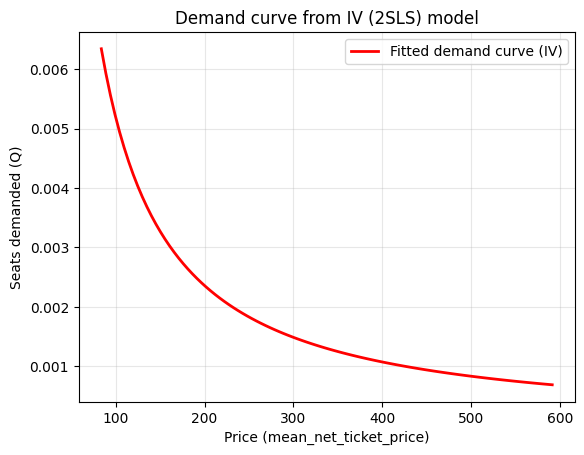

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

alpha = iv4.params["const"] if "const" in iv2.params else 0.0
beta  = iv4.params["log_price"]

# For fitted demand curve, pick a reasonable price range
p_min, p_max = dat["P"].quantile([0.005, 0.995])
P_grid = np.linspace(p_min, p_max, 100)
Q_fit = np.exp(alpha) * (P_grid ** beta)

plt.plot(P_grid, Q_fit, color="red", linewidth=2, label="Fitted demand curve (IV)")

# --- Step 3: Labels and aesthetics ---
plt.xlabel("Price (mean_net_ticket_price)")
plt.ylabel("Seats demanded (Q)")
plt.title("Demand curve from IV (2SLS) model")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


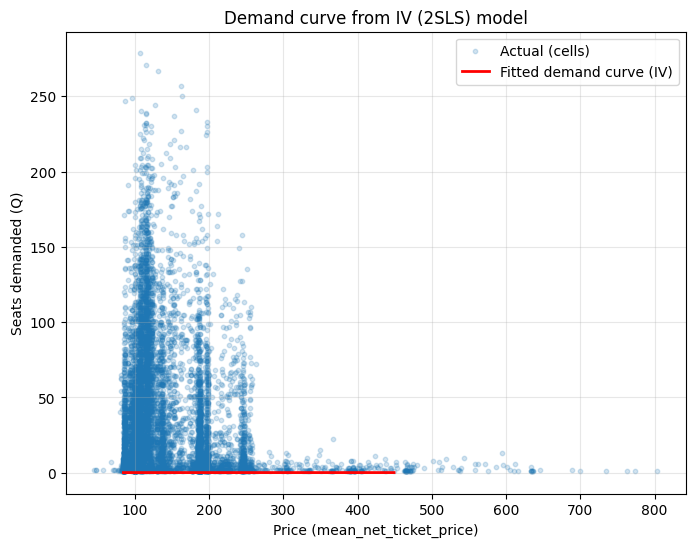

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Take actual observed scatter (log scale back to original) ---
plt.figure(figsize=(8,6))
plt.scatter(dat["P"], dat["Q"], alpha=0.2, s=10, label="Actual (cells)")

# --- Step 2: Fitted demand curve from 2SLS ---
alpha = iv4.params["const"] if "const" in iv2.params else 0.0
beta  = iv4.params["log_price"]

# For fitted demand curve, pick a reasonable price range
p_min, p_max = dat["P"].quantile([0.01, 0.99])
P_grid = np.linspace(p_min, p_max, 100)
Q_fit = np.exp(alpha) * (P_grid ** beta)

plt.plot(P_grid, Q_fit, color="red", linewidth=2, label="Fitted demand curve (IV)")

# --- Step 3: Labels and aesthetics ---
plt.xlabel("Price (mean_net_ticket_price)")
plt.ylabel("Seats demanded (Q)")
plt.title("Demand curve from IV (2SLS) model")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


#### ***Results Summary***

##### **Instrument relevance (First Stage):**

    lnIV → log_price: β = −8.18, t = −10.86, partial R² = 0.057.

There’s a strong first stage in a large sample (partial R²≈5–6% is solid; t≈11 is well above weak-IV thresholds). The negative sign just means your leave-one-train-out monthly price moves opposite your train’s price (consistent with network yield-management or substitutability across trains).

##### **Causal price elasticity (Second Stage, 2SLS):**

    ε̂ = −1.142 (StdErr 0.190, p < 1e-8, 95% CI −1.515 to −0.769).

Interpretation (log–log): a 10% higher price reduces seats by ~11.4% on average, controlling for booking-window shape (spline), cabin, trip type, customer segment, train fixed effects, year-month and day-of-week. **Demand is elastic (< −1)**.

##### **Internal consistency checks:**

* Wald identity: RF/FS = −1.14205, matches 2SLS to machine precision (difference ≈ −2.8e-11).

* Estimator robustness: LIML equals 2SLS (same coef, same SE).

* Bootstrap (cluster pairs): center of the resamples ≈ −1.14 as well, so your inference is stable. (Our printed “bootstrap p-value” tested whether the point estimate was extreme compared to the bootstrap center; for a significance test vs 0 you’d instead check how often the bootstrap coef crosses 0.)

##### **GMM anomaly:**

You saw IV-GMM ≈ 0.0036 with tiny SE. In a just-identified model, IV-GMM should equal 2SLS/LIML. That near-zero estimate almost surely reflects a setup quirk (e.g., different columns/constant passed, or an internal singular weighting issue). Given 2SLS, LIML, and Wald all agree, treat GMM as a mis-spec artifact unless you need it (and if you do, standardize variables and ensure the same const & regressors are passed).

##### **Does this give a clear modeling picture?**

Yes, we now have:

* A credible instrument (leave-one-train-out monthly price), strong on first stage and plausibly exogenous conditional on your rich FE/control set.

* A stable causal elasticity around −1.1 that persists across 2SLS, LIML, Wald and bootstrap checks.

* Granular controls (train FE, YM FE, DOW FE, booking-window spline, cabin/trip/customer effects), with clustering at Train×YM for reliable inference.

##### **Practical implications:**

With ε ≈ −1.14, demand is elastic: price increases are likely to reduce revenue for a given train/cabin cell (unless marginal costs or spillovers justify it).

Segment controls (Normal cabin, “Both”/“Return only”, Customer B) show systematic level shifts in quantity, while price sensitivity is captured by the common elasticity. We can extend to heterogeneous elasticity if needed (see below).

**Aggregated Market Model (Normal-cabin specific)**

In [ ]:
# Data requirements: df with columns
#   'Train_Number_All', 'Dept_Date', 'Purchase_Date' OR 'days_to_departure',
#   'num_seats_total', 'mean_net_ticket_price', 'isNormCabin'
# Produces: 2SLS elasticity for Normal cabin, clustered by Train×YM

import numpy as np, pandas as pd, re
from patsy import dmatrix
import statsmodels.api as sm
from linearmodels.iv import IV2SLS, IVLIML

# ---------- helpers ----------
def ensure_vars(df):
    out = df.copy()
    # booking window
    if "days_to_departure" in out.columns:
        out["days_advance"] = pd.to_numeric(out["days_to_departure"], errors="coerce")
    elif "days_advance" not in out.columns:
        out["Dept_Date"]     = pd.to_datetime(out["Dept_Date"], errors="coerce")
        out["Purchase_Date"] = pd.to_datetime(out["Purchase_Date"], errors="coerce")
        out["days_advance"]  = (out["Dept_Date"] - out["Purchase_Date"]).dt.days

    # cabin
    if "CabinType" not in out.columns:
        out["CabinType"] = np.where(out["isNormCabin"].astype(int)==1, "Normal", "Special")

    # ym + dow
    out["Dept_Date"] = pd.to_datetime(out["Dept_Date"], errors="coerce")
    out["ym"]  = out["Dept_Date"].dt.to_period("M").astype(str)
    out["dow"] = out["Dept_Date"].dt.day_name()

    # basic numerics
    for c in ["num_seats_total","mean_net_ticket_price","days_advance"]:
        if c in out: out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def aggregate_cells(df):
    """
    One row per (Train, Date, Cabin):
      Q=sum seats; P=median price; DA_med=median days_advance; ym; dow
    """
    tx = df.copy()
    tx["Dept_Date"] = pd.to_datetime(tx["Dept_Date"], errors="coerce").dt.normalize()
    need = ["Train_Number_All","Dept_Date","CabinType","num_seats_total","mean_net_ticket_price","days_advance"]
    tx = tx.dropna(subset=need)
    tx["ym"]  = tx["Dept_Date"].dt.to_period("M").astype(str)
    tx["dow"] = tx["Dept_Date"].dt.day_name()

    keys = ["Train_Number_All","Dept_Date","CabinType"]
    tx["Q"]      = tx.groupby(keys)["num_seats_total"].transform("sum")
    tx["P"]      = tx.groupby(keys)["mean_net_ticket_price"].transform("median")
    tx["DA_med"] = tx.groupby(keys)["days_advance"].transform("median")

    cells = (tx[keys+["ym","dow","Q","P","DA_med"]]
             .drop_duplicates(subset=keys)
             .reset_index(drop=True))
    cells["lnQ"] = np.log(cells["Q"].clip(lower=1))
    cells["log_price"] = np.log(cells["P"].clip(lower=1e-6))
    return cells

def loo_month_iv(cells):
    """
    IV: month-level mean price of OTHER trains (leave-one-train-out).
    """
    mo   = cells.groupby("ym")["P"].agg(["sum","count"]).rename(columns={"sum":"sum_all","count":"n_all"}).reset_index()
    trym = cells.groupby(["Train_Number_All","ym"])["P"].agg(["sum","count"]).rename(columns={"sum":"sum_tr","count":"n_tr"}).reset_index()

    base = (cells.merge(trym, on=["Train_Number_All","ym"], how="left")
                 .merge(mo,   on="ym",                    how="left"))

    num = base["sum_all"] - base["sum_tr"]
    den = (base["n_all"]  - base["n_tr"]).replace(0, np.nan)
    base["IV_P"] = num / den
    base["lnIV"] = np.log(base["IV_P"].clip(lower=1e-6))
    return base

def bs_spline_days(x, df=6, degree=3):
    X = dmatrix(f"bs(x, df={df}, degree={degree}, include_intercept=False)",
                {"x": pd.Series(x).fillna(pd.Series(x).median())},
                return_type="dataframe")
    # tidy column names
    X.columns = [re.sub(r"[^0-9A-Za-z_]+","_", c) for c in X.columns]
    return X

# ---------- pipeline ----------
# 1) prep & aggregate
df1    = ensure_vars(df)
cells  = aggregate_cells(df1)
cells  = loo_month_iv(cells)

# 2) keep Normal cabin only (homogeneous product)
dat = (cells
       .query("CabinType=='Normal'")
       .dropna(subset=["lnQ","log_price","lnIV","DA_med","Train_Number_All","ym","dow"])
       .copy())

# 3) design: exog = const + spline(days) + Train FE + YM FE + DOW FE
Xs = bs_spline_days(dat["DA_med"], df=6)
D_train = pd.get_dummies(dat["Train_Number_All"], drop_first=True).astype(float)
D_ym    = pd.get_dummies(dat["ym"],               drop_first=True).astype(float)
D_dow   = pd.get_dummies(dat["dow"],              drop_first=True).astype(float)  # <- NEW

X_exog = pd.concat([Xs, D_train, D_ym, D_dow], axis=1)
X_exog.insert(0, "const", 1.0)

# drop any zero-variance cols (keep const)
std = X_exog.std(axis=0, numeric_only=True)
X_exog = X_exog.loc[:, (X_exog.columns=="const") | (std>1e-12)]

y     = dat["lnQ"].astype(float)
X_end = dat[["log_price"]].astype(float)
Z     = dat[["lnIV"]].astype(float)

# clusters: Train×YM (many clusters improves reliability)
clusters = (dat["Train_Number_All"].astype(str) + "_" + dat["ym"].astype(str))

# 4) First-stage (diagnostics)
exog_rf = pd.concat([X_exog, Z], axis=1)
fs = sm.OLS(X_end.squeeze("columns"), exog_rf).fit(cov_type="cluster", cov_kwds={"groups": clusters})
beta_iv = float(fs.params["lnIV"]); se_iv = float(fs.bse["lnIV"]); t_iv = beta_iv/se_iv

# partial R² of lnIV | exog
rP = sm.OLS(X_end.squeeze("columns"), X_exog).fit().resid
rZ = sm.OLS(Z.squeeze("columns"),       X_exog).fit().resid
partial_R2 = float(np.corrcoef(rP, rZ)[0,1]**2)

print(f"N (Normal cells): {len(dat):,} | Clusters (Train×YM): {clusters.nunique():,}")
print("[First-stage] ",
      {"beta_lnIV": beta_iv, "t (cluster)": t_iv, "Partial R^2 (lnIV | exog)": partial_R2})

# 5) 2SLS (just-identified), clustered
iv5 = IV2SLS(y, X_exog, X_end, Z).fit(cov_type="clustered", clusters=clusters)
beta = float(iv5.params["log_price"]); se = float(iv5.std_errors["log_price"])
pval = float(iv5.pvalues["log_price"]); ci = tuple(iv5.conf_int().loc["log_price"].to_numpy().astype(float))

print("\n[IV-2SLS (Normal only, +DOW FE)]")
print({"Elasticity (log_price)": beta, "SE": se, "p": pval, "95% CI": ci})

# 6) Wald identity check (sanity)
rf = sm.OLS(y, exog_rf).fit(cov_type="cluster", cov_kwds={"groups": clusters})
wald = float(rf.params["lnIV"] / fs.params["lnIV"])
print("\n[Wald identity]")
print({"RF lnIV": float(rf.params["lnIV"]), "FS lnIV": float(fs.params["lnIV"]),
       "Wald ratio (RF/FS)": wald, "2SLS log_price": beta, "diff": beta - wald})

# Optional: LIML should agree with 2SLS when identification is clean
liml = IVLIML(y, X_exog, X_end, Z).fit(cov_type="clustered", clusters=clusters)
print("\n[LIML] ", {"log_price": float(liml.params["log_price"]), "SE": float(liml.std_errors["log_price"])})

# Nice compact text summary
try:
    print("\n=== IV-2SLS model summary ===")
    print(iv5.summary)
except Exception:
    pass


N (Normal cells): 7,788 | Clusters (Train×YM): 326
[First-stage]  {'beta_lnIV': -6.832708041516083, 't (cluster)': -7.871658103865959, 'Partial R^2 (lnIV | exog)': 0.0538950274122066}

[IV-2SLS (Normal only, +DOW FE)]
{'Elasticity (log_price)': -1.747136705851517, 'SE': 0.32832564940457026, 'p': 1.0299827502002756e-07, '95% CI': (np.float64(-2.3906431538851995), np.float64(-1.1036302578178345))}

[Wald identity]
{'RF lnIV': 11.937675020042175, 'FS lnIV': -6.832708041516083, 'Wald ratio (RF/FS)': -1.7471367059016574, '2SLS log_price': -1.747136705851517, 'diff': 5.014033632733117e-11}

[LIML]  {'log_price': -1.7471367058506075, 'SE': 0.32832564940741965}

=== IV-2SLS model summary ===
                          IV-2SLS Estimation Summary                          
Dep. Variable:                    lnQ   R-squared:                      0.6758
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6737
No. Observations:                7788   F-statistic:                 1

#### ***Results Summary***

##### **Price elasticity (Normal cabin):**

    −1.75 (SE ≈ 0.33, p ≈ 1.03e-7, 95% CI ≈ [−2.39, −1.10]).
→ Demand is elastic; a 1% price increase reduces seats sold by ~1.75%.

##### **First-stage strengths:**

    Coef on lnIV = −6.83, cluster t ≈ −7.87.

    Partial R² ≈ 0.054.

With one endogenous regressor, a cluster t of ~8 implies a healthy first stage (roughly t²≈64). Not razor-sharp, but not weak.

##### **Internal consistency checks (all lining up):**

* Wald identity = −1.7471 and 2SLS = −1.7471 (difference ~5×10⁻¹¹) → perfect bookkeeping on the same rows.

* LIML estimate equals 2SLS (same SE) → no red flag from weak-IV bias.

##### **Fit (descriptive, not causal):**

    R² ≈ 0.67 on lnQ with rich FE + spline
    RMSE ≈ 0.84, MAE ≈ 0.62.

→ This is strong for an aggregated market model

##### **Possible Improvements**

* Instrument strength: Partial R² ≈ 0.05 is moderate. Given the large N and t≈8, you’re okay, but you’re not swimming in instrument power. The fact that LIML ≈ 2SLS and the Wald identity matches is reassuring.

* Exclusion restriction: The leave-one-train-out, month-level IV + month FE is a good design: common month shocks are absorbed by FE, and you use cross-train variation. The remaining risk is route-specific month shocks that move all trains’ prices in ways correlated with demand within a route. You partly handle this via train FE, but it’s something to keep in mind.

* Just-identified model: Over-ID tests (Sargan/AR overidentification) aren’t available here by design. That’s not a flaw—just means you can’t statistically test the IV’s exogeneity.

##### **Model Conclusion:**

The model is statistically reliable for Normal cabin: strong negative elasticity, decent first stage and internal checks agree.

Economically, −1.7 is plausible for rail/coach demand at this aggregation level.

**Calibration by predicted decile (Poisson 2SRI + YM-FE)**

To assess how well the model’s score orders demand, we group transactions into ten bins by predicted seats and
compare the mean actual vs mean predicted in each bin. The curve rises steadily from D1 to D10, showing strong rank
ordering (higher scores → higher realized demand). Calibration is tight in the middle deciles, with slight under-
prediction around D6–D7 and mild over-prediction at the very top; the shaded bars indicate balanced sample sizes
across deciles, so these patterns aren’t driven by tiny cells. Practically, this means the model is dependable for
prioritizing inventory/pricing toward top deciles and suggests a modest intercept/scale tweak if perfect calibration is
needed at the extremes

### ***Poisson Model***

##### **Why Poisson?**
*   Your outcome is a count (num_seats_total ∈ {0,1,2,…}). Poisson GLM respects that: non-negative predictions and a natural mean–variance link for skewed counts.
*   Heteroskedasticity by design. In count data, variance rises with the mean; OLS treats noise as constant → inefficient and can distort inference.
*   Elasticity is clean. With a log link and log_price on the RHS, the coefficient on log_price is a price elasticity directly.

##### **Why Poisson + IV (2SRI / control function)?**

* Price is endogenous. Demand shocks (unobserved) move both price and seats.
* YM fixed effects soak up month-wide shocks (seasonality, holidays), so identification is within month.

**2SRI fixes in a nonlinear model:**

* First stage: regress log_price on the instrument lnIV + controls/FE → get residual rhat.
* Second stage (Poisson GLM): regress seats on log_price, rhat, and controls/FE. Including rhat “purges” the endogeneity of log_price.

---

In [ ]:
# === Poisson IV via Control Function (2SRI) with Year–Month FE ===
# Outcome: num_seats_total (counts, >=0)
# Endogenous regressor: log_price = ln(mean_net_ticket_price)
# Instrument: lnIV = ln(iv_price_loo)
# FE: C(ym); Controls: days_to_departure, TripLegType, CabinType, Customer_Cat
# SEs: clustered by Train_Number_All

import numpy as np, pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

# ---------- 0) Start from your IV+YM-FE sample ----------
base = dff.copy()

# Ensure needed columns exist
for c in ["Dept_Date","Purchase_Date"]:
    if c in base.columns:
        base[c] = pd.to_datetime(base[c], errors="coerce")
if "ym" not in base.columns:
    if "Dept_Date" in base and base["Dept_Date"].notna().any():
        base["ym"] = base["Dept_Date"].dt.to_period("M").astype(str)     # 'YYYY-MM'
    elif "Purchase_Date" in base and base["Purchase_Date"].notna().any():
         base["ym"] = base["Purchase_Date"].dt.to_period("M").astype(str)
    else:
        raise ValueError("Need Dept_Date or Purchase_Date to construct ym.")

if "days_to_departure" not in base.columns and {"Dept_Date","Purchase_Date"}.issubset(base.columns):
    base["days_to_departure"] = (base["Dept_Date"] - base["Purchase_Date"]).dt.days


if "trip_type" not in base.columns and {"isOneway","isReturn"}.issubset(base.columns):
    base["trip_type"] = np.select(
        [base["isOneway"].eq(1), base["isReturn"].eq(1)],
        ["Oneway",               "Return"],
        default="Neither"
    )
if "CabinType" not in base.columns and "isNormCabin" in base.columns:
    base["CabinType"] = base["isNormCabin"].map({0:"Special", 1:"Normal"})

# Leave-one-out IV if missing
if "iv_price_loo" not in base.columns:
    g = (base.groupby(["Train_Number_All","ym"])["mean_net_ticket_price"]
             .agg(sum_p="sum", n_p="count").reset_index())
    base = base.merge(g, on=["Train_Number_All","ym"], how="left")
    base["iv_price_loo"] = np.where(
        base["n_p"]>1,
        (base["sum_p"] - base["mean_net_ticket_price"]) / (base["n_p"] - 1),
        np.nan
    )

# Clean sample
dfp = base[(base["mean_net_ticket_price"]>0) &
           (base["num_seats_total"]>=0) &
           base["iv_price_loo"].notna()].copy()
if "days_to_departure" in dfp:
    dfp = dfp[dfp["days_to_departure"].ge(0)]

# Logs for CF approach
dfp["log_price"]  = np.log(dfp["mean_net_ticket_price"])
dfp["lnIV"] = np.log(dfp["iv_price_loo"])

# ---------- 1) First stage (price equation) ----------
fs_form = (
    "log_price ~ lnIV + days_to_departure "
    "+ C(trip_type , Treatment('Neither')) "
    "+ C(CabinType, Treatment('Special')) + C(Customer_Cat) + C(ym)"
)
fs = smf.ols(fs_form, data=dfp).fit(cov_type="HC3")
dfp["rhat"] = fs.resid  # control-function residual

# Optional: check instrument strength quickly
print("First-stage R²:", round(fs.rsquared, 4))

# ---------- 2) Second stage: Poisson GLM with log link + residual ----------
# (Clustered SE by train)
po_form = (
    "num_seats_total ~ log_price + rhat + demand_intensity +  days_to_departure "
    "+ C(trip_type, Treatment('Neither')) "
    "+ C(CabinType, Treatment('Special')) + C(Customer_Cat) + C(ym)"
)
po = smf.glm(po_form, data=dfp, family=sm.families.Poisson())
po_res = po.fit(cov_type="cluster", cov_kwds={"groups": dfp["Train_Number_All"]})
print(po_res.summary().tables[1])

# Elasticity in Poisson-log link with log_price regressor is directly the log_price coefficient
elas_poisson = float(po_res.params["log_price"])
print("Poisson-IV (2SRI) elasticity (log_price coef):", elas_poisson)

# ---------- 3) Quick fit diagnostics ----------
mu_hat = po_res.predict(dfp)                       # Poisson mean (non-negative)
y = dfp["num_seats_total"].to_numpy(dtype=float)
rmse = float(np.sqrt(np.mean((y - mu_hat)**2)))
mae  = float(np.mean(np.abs(y - mu_hat)))
# McFadden pseudo-R²: 1 - LL_full/LL_null
ll_full = float(po_res.llf)
ll_null = float(smf.glm("num_seats_total ~ 1", data=dfp,
                        family=sm.families.Poisson()).fit().llf)
pseudo_r2 = 1 - (ll_full/ll_null) if ll_null != 0 else np.nan
print({"RMSE": rmse, "MAE": mae, "PseudoR2_McFadden": pseudo_r2})

# ---------- 4) Mini calibration table by decile of predicted ----------
cal = pd.DataFrame({"actual": y, "pred": mu_hat})
cal["decile"] = pd.qcut(cal["pred"], q=10, duplicates="drop")
summ = (cal.groupby("decile")
          .agg(actual_mean=("actual","mean"),
               pred_mean=("pred","mean"),
               n=("actual","size"))
          .reset_index())
print("\nDecile means (head):")
print(summ.head())

First-stage R²: 0.6681
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        6.2767      1.524      4.118      0.000       3.289       9.264
C(trip_type, Treatment('Neither'))[T.Oneway]     0.0004      0.043      0.009      0.993      -0.083       0.084
C(trip_type, Treatment('Neither'))[T.Return]     0.0392      0.044      0.896      0.370      -0.047       0.125
C(CabinType, Treatment('Special'))[T.Normal]    -0.4471      0.143     -3.116      0.002      -0.728      -0.166
C(Customer_Cat)[T.B]                             0.1956      0.046      4.226      0.000       0.105       0.286
C(ym)[T.2018-07]                                -0.2444      0.044     -5.600      0.000      -0.330      -0.159
C(ym)[T.2018-08]                                -0.2685      0.063     -4

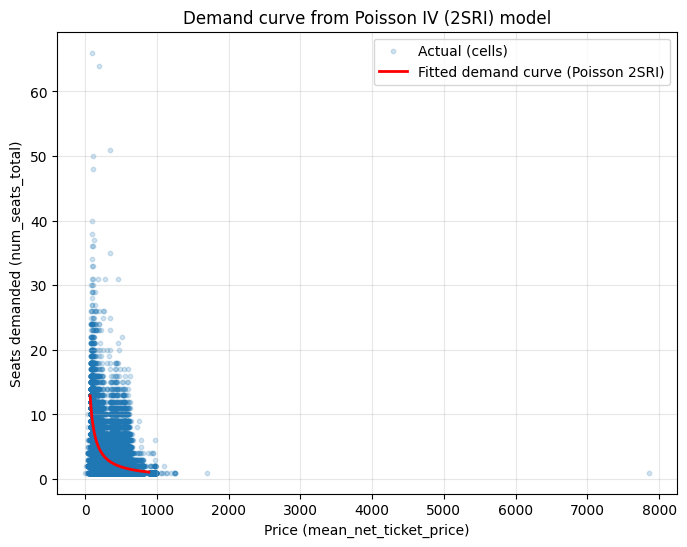

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Actual scatter of price vs seats ---
plt.figure(figsize=(8,6))
plt.scatter(dfp["mean_net_ticket_price"], dfp["num_seats_total"],
            alpha=0.2, s=10, label="Actual (cells)")

# --- 2. Predicted demand curve from Poisson-IV (2SRI) ---
# Model is log-link: E[Q|X] = exp(Xβ + offset)
# With log_price as regressor, elasticity = coef_log_price
# For plotting, we fix controls at their sample mean / reference categories

coef_price = po_res.params["log_price"]
const = po_res.params.get("Intercept", 0.0) if "Intercept" in po_res.params else 0.0

# Build baseline linear predictor: just intercept + mean of residual term
# (we ignore dummies here so it’s an "average" demand curve)
lp_base = const + dfp["rhat"].mean() + dfp["demand_intensity"].mean()

# Price grid over observed range
p_min, p_max = dfp["mean_net_ticket_price"].quantile([0.001, 0.999])
P_grid = np.linspace(p_min, p_max, 100)

# Poisson log-link fitted curve: μ(P) = exp(lp_base + β*ln(P))
Q_fit = np.exp(lp_base + coef_price * np.log(P_grid))

plt.plot(P_grid, Q_fit, color="red", linewidth=2, label="Fitted demand curve (Poisson 2SRI)")

# --- 3. Aesthetics ---
plt.xlabel("Price (mean_net_ticket_price)")
plt.ylabel("Seats demanded (num_seats_total)")
plt.title("Demand curve from Poisson IV (2SRI) model")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


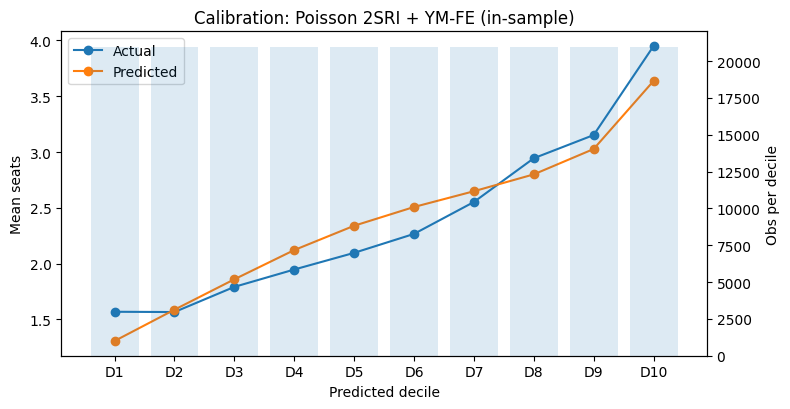

,decile,actual_mean,pred_mean,n,decile_num
0,"(0.603, 1.455]",1.568,1.306,20969,1
1,"(1.455, 1.723]",1.565,1.586,20969,2
2,"(1.723, 1.995]",1.791,1.859,20969,3
3,"(1.995, 2.24]",1.947,2.121,20969,4
4,"(2.24, 2.43]",2.096,2.339,20969,5
5,"(2.43, 2.58]",2.266,2.507,20969,6
6,"(2.58, 2.716]",2.552,2.648,20969,7
7,"(2.716, 2.896]",2.944,2.800,20969,8
8,"(2.896, 3.185]",3.152,3.027,20969,9
9,"(3.185, 83.134]",3.950,3.637,20969,10


In [ ]:
#Decile-plot
import matplotlib.pyplot as plt

def calibration_deciles(y, yhat, q=10, title="Calibration: Poisson 2SRI + YM-FE", save_as=None):
    cal = pd.DataFrame({"actual": np.asarray(y,float), "pred": np.asarray(yhat,float)})
    cal = cal.replace([np.inf,-np.inf], np.nan).dropna()
    cal["decile"] = pd.qcut(cal["pred"], q=q, duplicates="drop")
    summ = (cal.groupby("decile", observed=True)
              .agg(actual_mean=("actual","mean"),
                   pred_mean  =("pred","mean"),
                   n          =("actual","size"))
              .reset_index())
    # order left→right
    summ["decile_num"] = summ["decile"].cat.codes + 1
    summ = summ.sort_values("decile_num").reset_index(drop=True)

    # --- plot ---
    x = summ["decile_num"].to_numpy()
    fig, ax = plt.subplots(figsize=(8,4.2))
    ax.plot(x, summ["actual_mean"], marker="o", label="Actual")
    ax.plot(x, summ["pred_mean"],   marker="o", label="Predicted")
    ax.set_xticks(x); ax.set_xticklabels([f"D{i}" for i in x])
    ax.set_xlabel("Predicted decile"); ax.set_ylabel("Mean seats")
    ax.set_title(title); ax.legend()
    ax2 = ax.twinx()
    ax2.bar(x, summ["n"], alpha=0.15)
    ax2.set_ylabel("Obs per decile")
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, dpi=200, bbox_inches="tight")
    plt.show()
    return summ

# use with your Poisson fit:
if 'po_res' in globals():
    dfp = po_res.model.data.frame
    y = dfp['num_seats_total'].to_numpy(float)
    mu_hat = po_res.predict(dfp)
    decile_tbl = calibration_deciles(y, mu_hat, q=10,
                                     title="Calibration: Poisson 2SRI + YM-FE (in-sample)",
                                     save_as="cal_poisson2sri.png")
    with pd.option_context('display.float_format','{:,.3f}'.format):
        display(decile_tbl)
    # decile_tbl.to_csv("calibration_deciles_poisson.csv", index=False)


#### ***Results Summary***
**Price elasticity (causal, IV-corrected)**: −0.98 (p<0.001). With the log link and log_price regressor, the coefficient is the elasticity: a 1% higher price is associated with ≈0.98% fewer seats demanded on average, holding controls and year-month fixed effects constant. That’s close to unit elastic.

**Endogeneity is present and corrected**: The first stage is strong (R²≈0.67), and the control-function residual (rhat) is positive and significant (p≈0.004), indicating price was endogenous; including rhat addresses this.

**Controls behave sensibly.**

* **demand_intensity** is strongly positive (≈0.224), raising expected seats.

* **days_to_departure** is small negative (≈−0.002), suggesting slightly lower bookings further from departure (given other controls).

* **Normal vs Special cabin** dummy is negative (≈−0.45), meaning the Normal cabin cell has lower expected counts than Special, conditional on covariates.

* **YM fixed effects** soak up common monthly shocks; trip type and customer category are included.

**Model fit/diagnostics**. McFadden pseudo-R² ≈ 0.052 (typical for Poisson on micro data). The decile calibration looks reasonable.

**Bottom line**: After instrumenting price and controlling for time/cabin composition, demand responds negatively and nearly proportionally to price (≈−1 elasticity).

### ***Tables & Graphs***
---

Text(0.5, 1.0, 'Price by Customer Category')

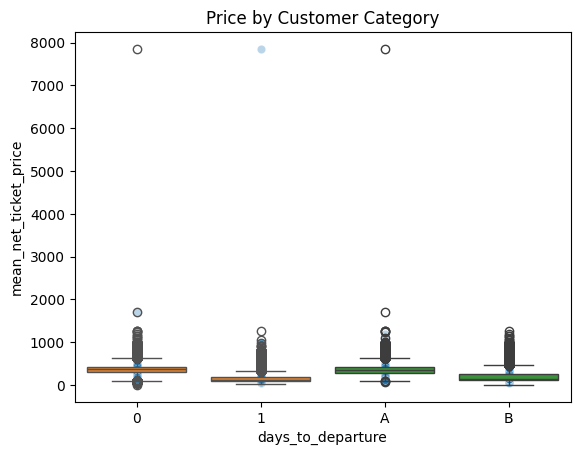

In [ ]:
#Understanding variables correlation with price
#Price vs Days to Departure
sns.scatterplot(data=df, x='days_to_departure', y='mean_net_ticket_price', alpha=0.3)
plt.title("Price vs Days to Departure")

#Price by Cabin Type
sns.boxplot(data=df, x='isNormCabin', y='mean_net_ticket_price')
plt.title("Price by Cabin Type")

#Price by Customer Category
sns.boxplot(data=df, x='Customer_Cat', y='mean_net_ticket_price')
plt.title("Price by Customer Category")

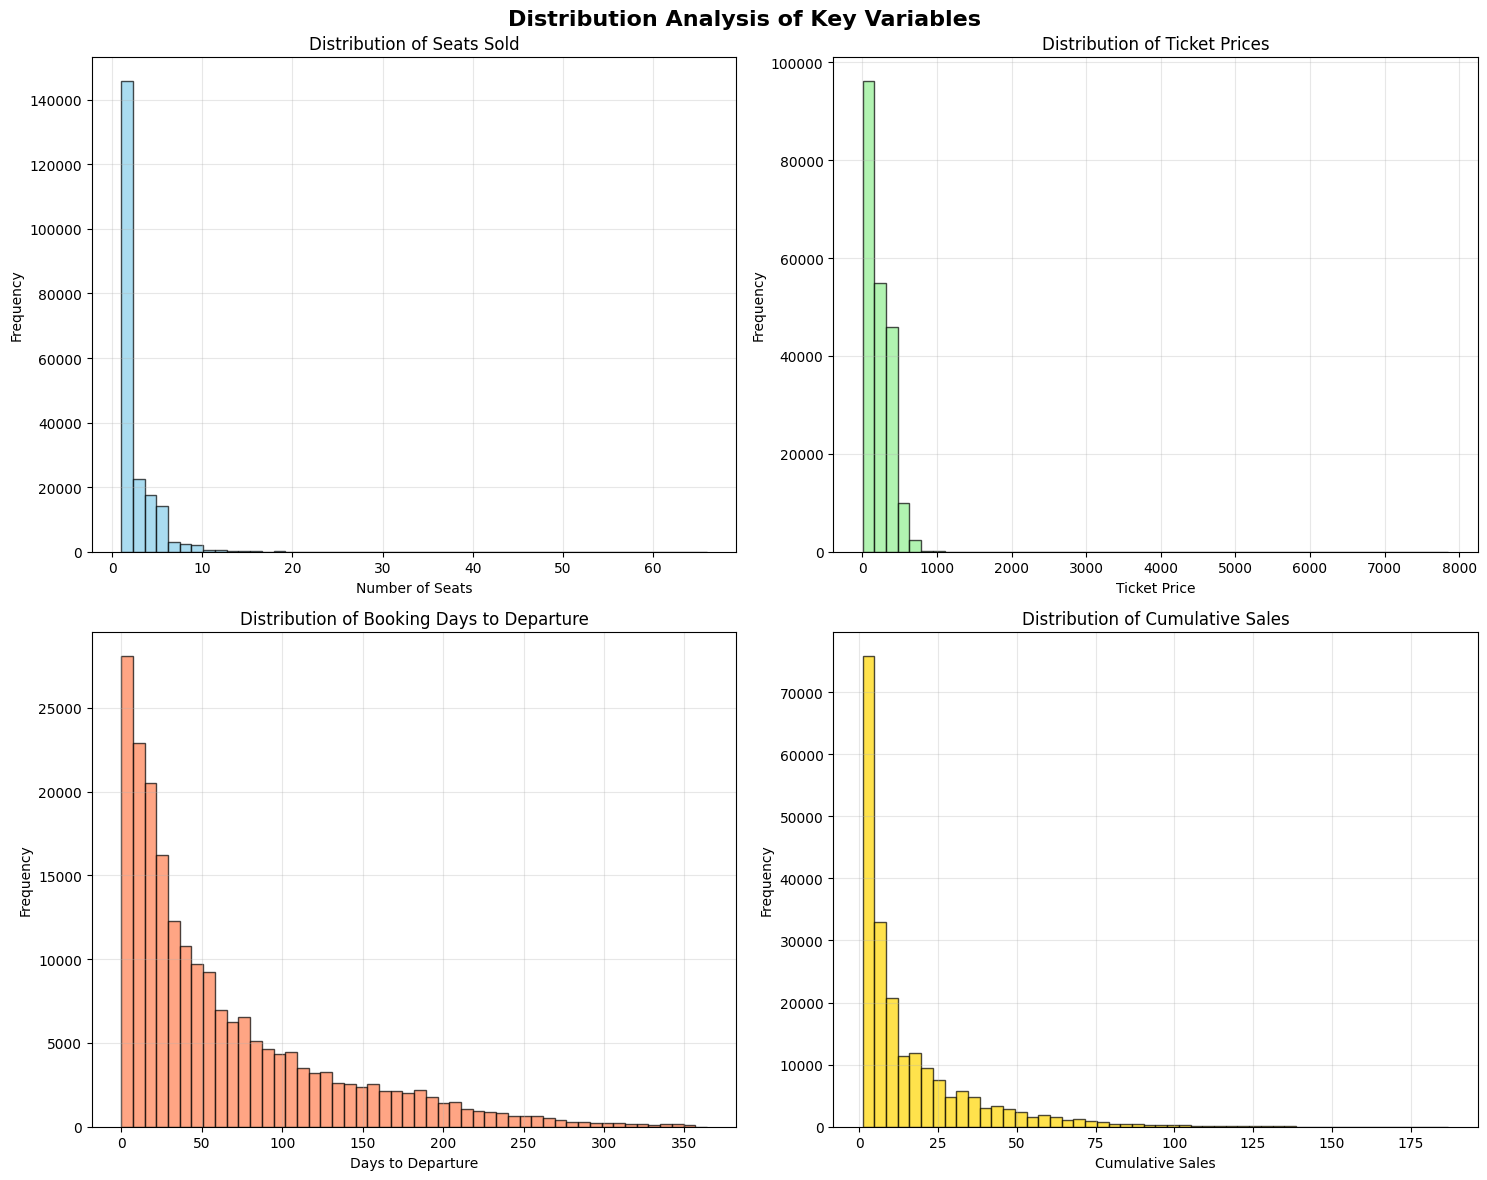

In [ ]:
#Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution Analysis of Key Variables', fontsize=16, fontweight='bold')

#Seats distribution
axes[0,0].hist(df['num_seats_total'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Seats Sold')
axes[0,0].set_xlabel('Number of Seats')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

#Price distribution
axes[0,1].hist(df['mean_net_ticket_price'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribution of Ticket Prices')
axes[0,1].set_xlabel('Ticket Price')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

#Days to Departure distribution
if df['days_to_departure'].std() > 0:
  axes[1,0].hist(df['days_to_departure'], bins=50, alpha=0.7, color='coral', edgecolor='black')
  axes[1,0].set_title('Distribution of Booking Days to Departure')
  axes[1,0].set_xlabel('Days to Departure')
  axes[1,0].set_ylabel('Frequency')
  axes[1,0].grid(True, alpha=0.3)

else:
      axes[1,0].text(0.5, 0.5, 'All bookings same day', ha='center', va='center', transform=axes[1,0].transAxes)
      axes[1,0].set_title('Days to Departure (No Variation)')

#Cumulative sales distribution
axes[1,1].hist(df['Culmulative_sales'], bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[1,1].set_title('Distribution of Cumulative Sales')
axes[1,1].set_xlabel('Cumulative Sales')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("distribution_analysis.pdf", format="pdf")

plt.show()

Closer Look at Key Variables


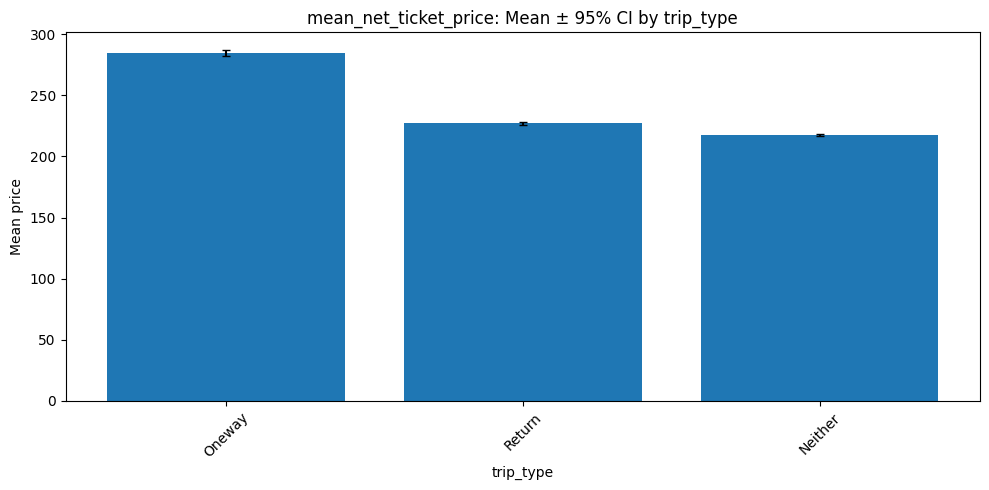

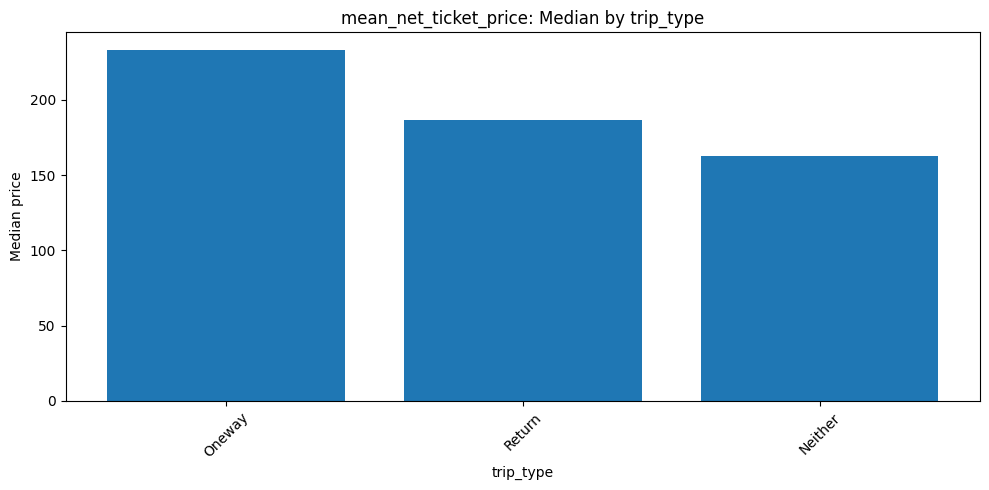

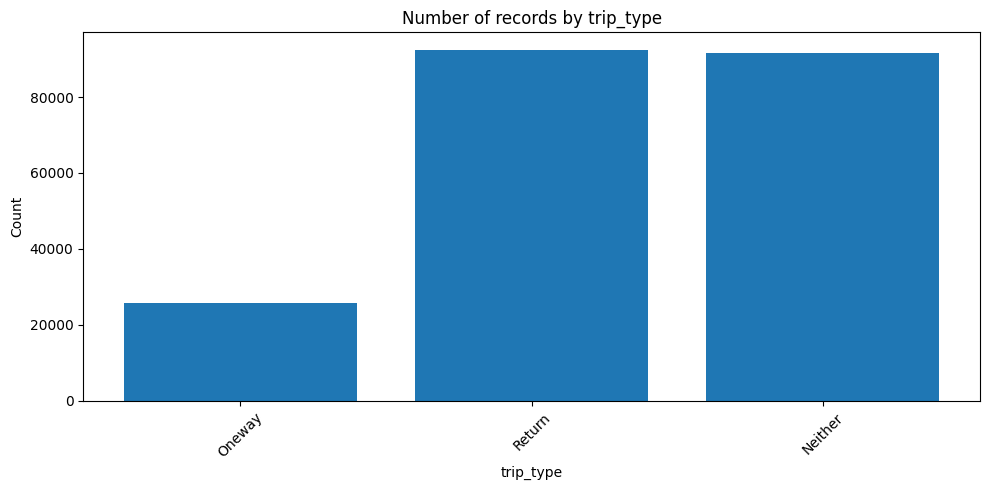

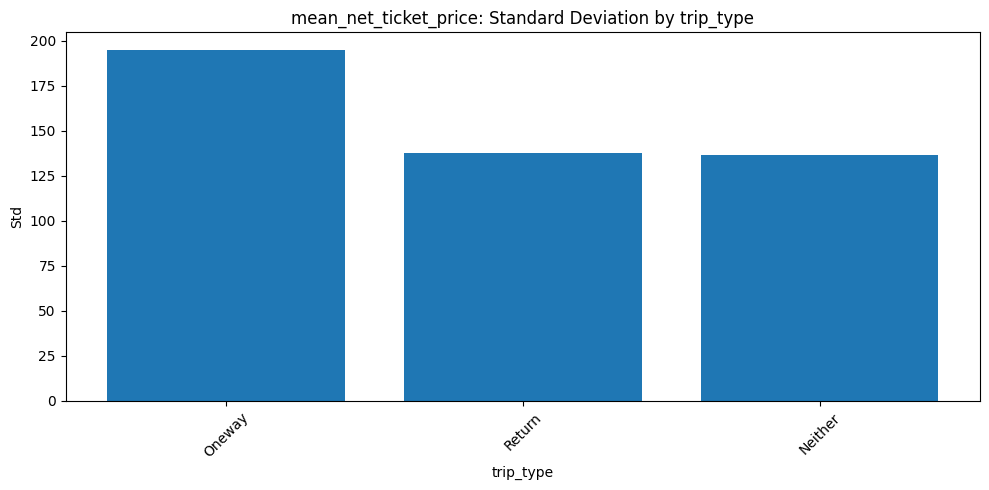

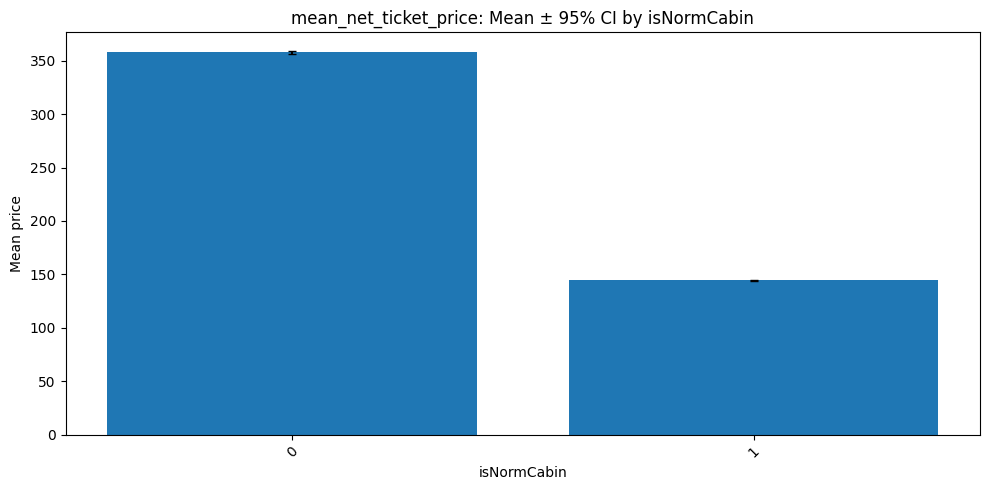

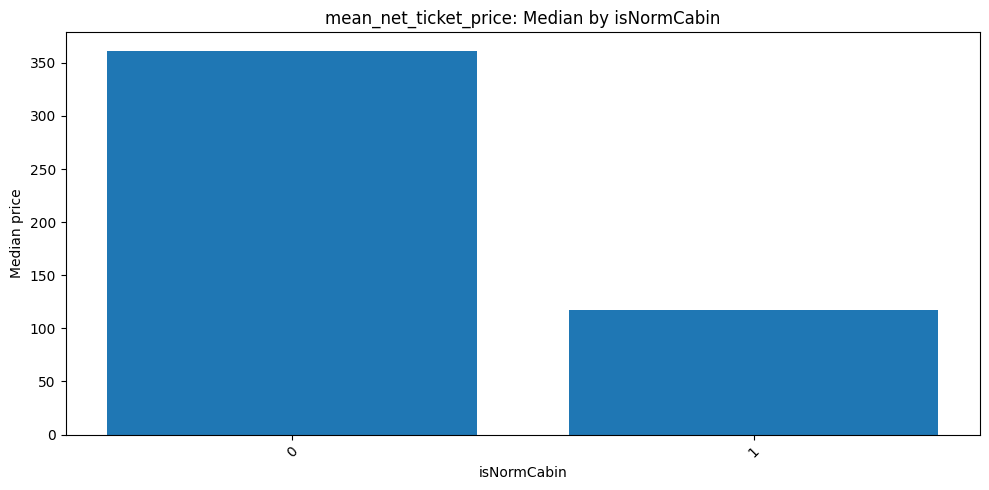

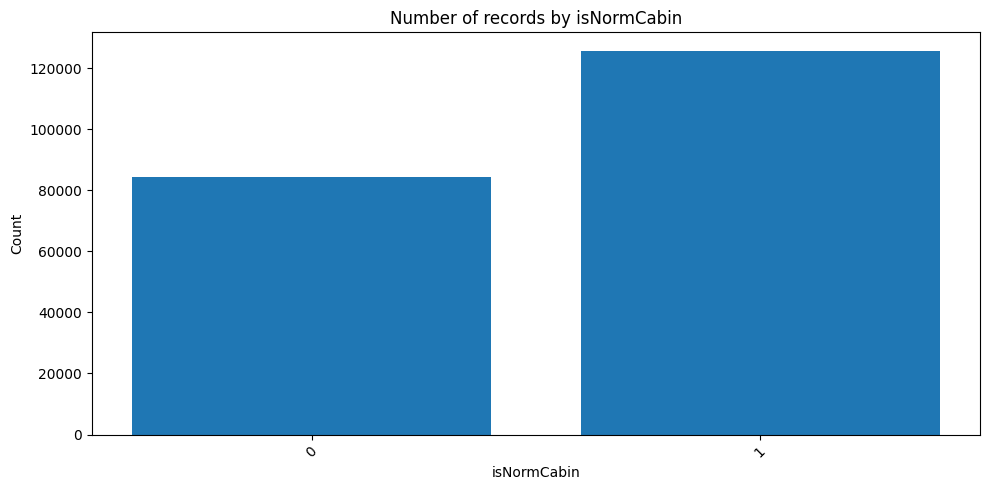

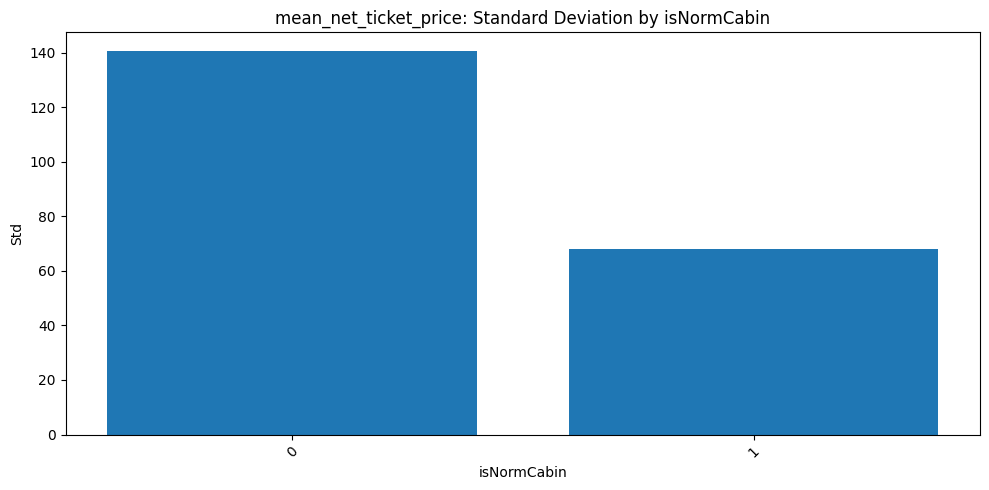

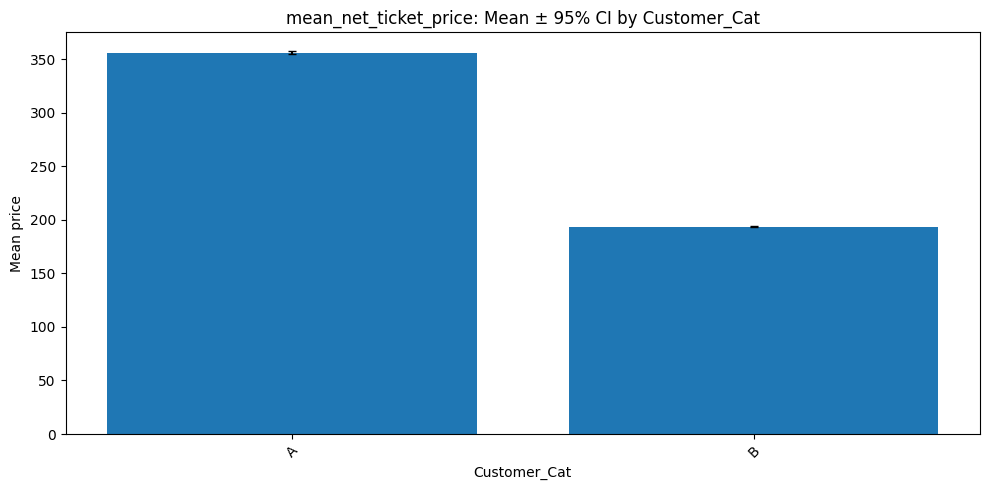

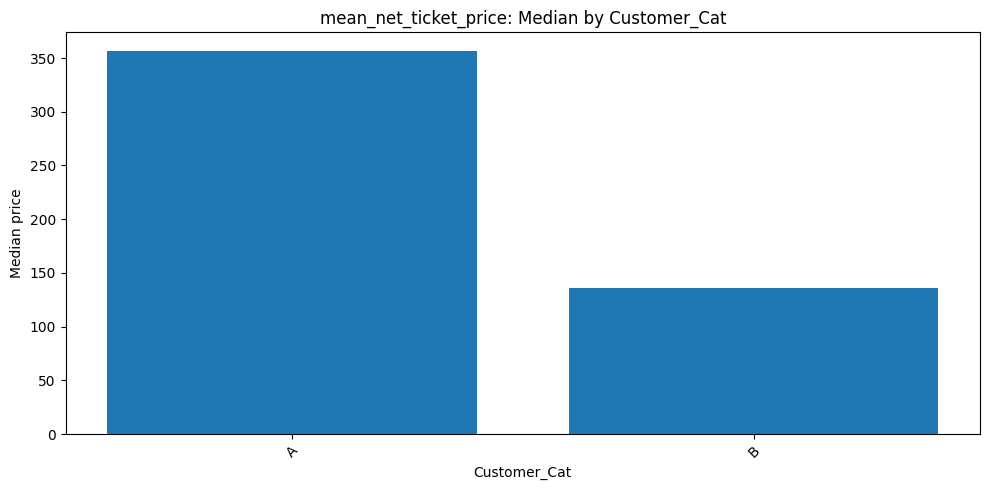

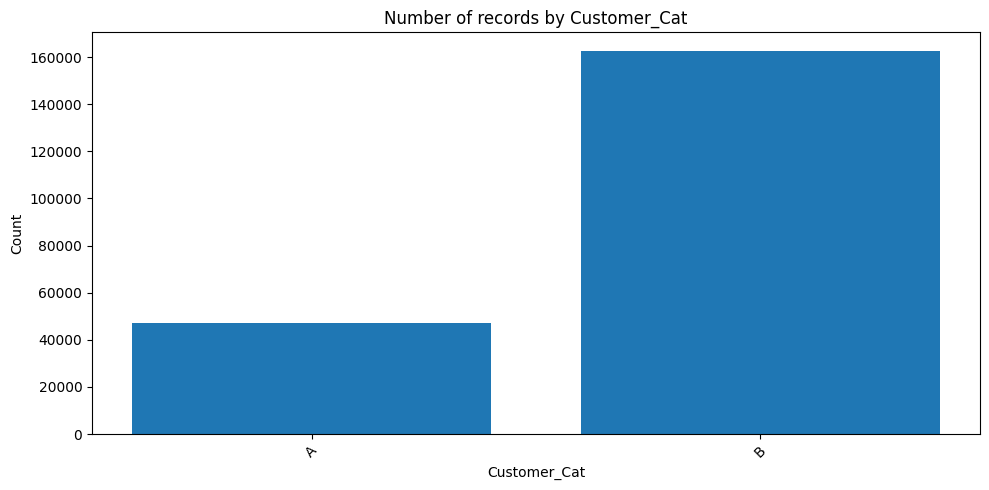

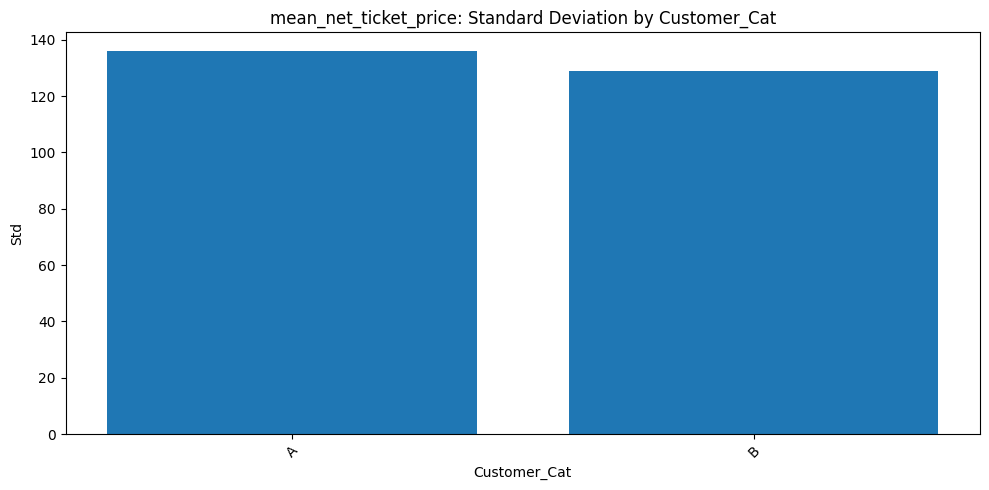

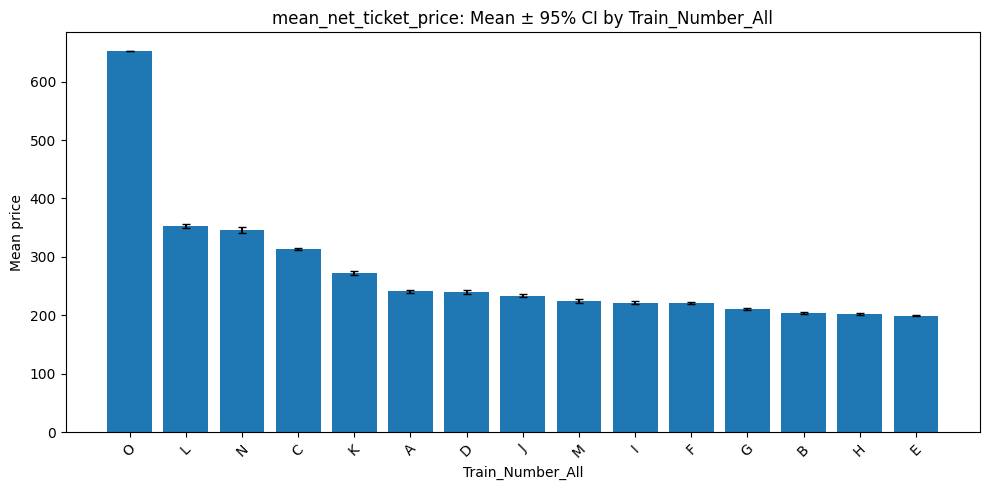

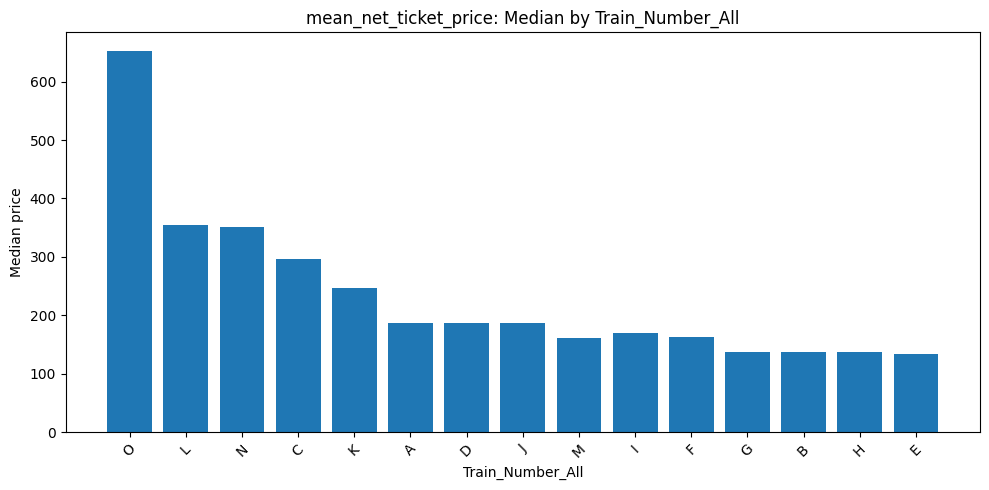

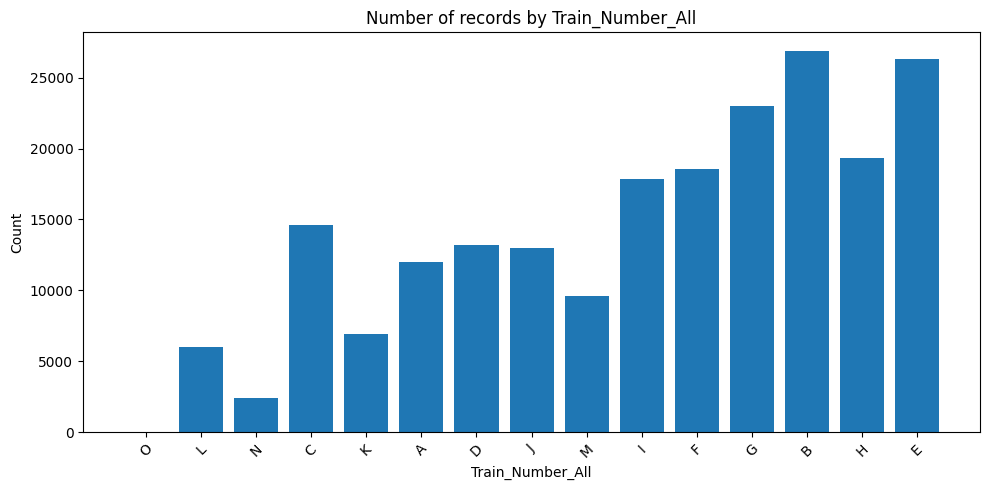

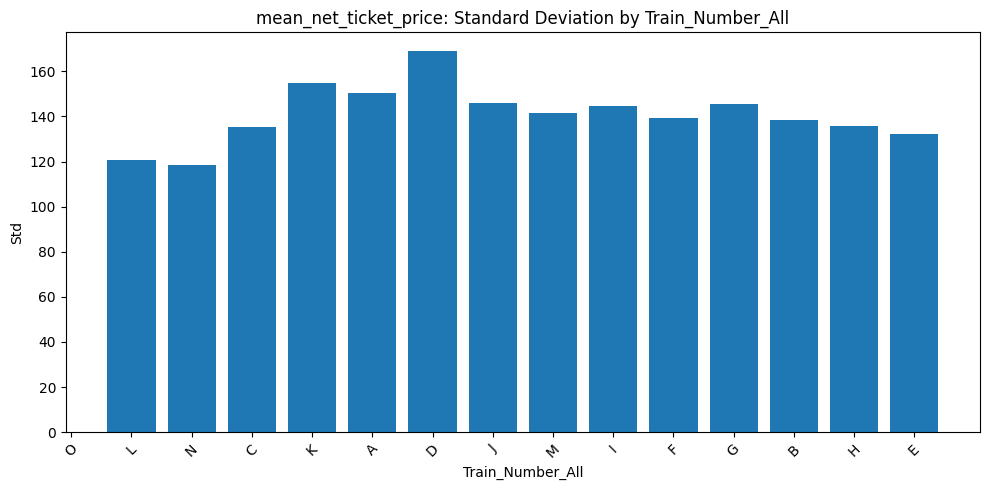

In [ ]:
print('Closer Look at Key Variables')

price_col = 'mean_net_ticket_price'
def plot_cat_summary(df, col, top_n=15, sort_by='mean'):
    g = (df.groupby(col)[price_col]
           .agg(['count','mean','median','std'])
           .sort_values(sort_by, ascending=False))
    if len(g) > top_n:
        g = g.head(top_n)

    g = g.reset_index()
    g[col] = g[col].astype(str)
    se = g['std'] / np.sqrt(g['count'])

#Confidence Interval for Mean Price
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(g[col], g['mean'], yerr=(1.96*se).fillna(0), capsize=3)
    ax.set_title(f'{price_col}: Mean ± 95% CI by {col}')
    ax.set_xlabel(col); ax.set_ylabel('Mean price')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout(); plt.show()

#Median Price
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(g[col], g['median'])
    ax.set_title(f'{price_col}: Median by {col}')
    ax.set_xlabel(col); ax.set_ylabel('Median price')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout(); plt.show()

#Segmentation via `trip_type`
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(g[col], g['count'])
    ax.set_title(f'Number of records by {col}')
    ax.set_xlabel(col); ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout(); plt.show()

#Std via `trip_type`
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(g[col], g['std'])
    ax.set_title(f'{price_col}: Standard Deviation by {col}')
    ax.set_xlabel(col); ax.set_ylabel('Std')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout(); plt.show()

#Other Data Analysis
for c in ['trip_type', 'isNormCabin', 'Customer_Cat']:
    if c in df.columns:
        plot_cat_summary(df, c, top_n=10, sort_by='mean')

if 'Train_Number_All' in df.columns:
    top_trains = df['Train_Number_All'].value_counts().head(15).index
    plot_cat_summary(df[df['Train_Number_All'].isin(top_trains)], 'Train_Number_All', top_n=15, sort_by='mean')

Market Segmentation Analysis


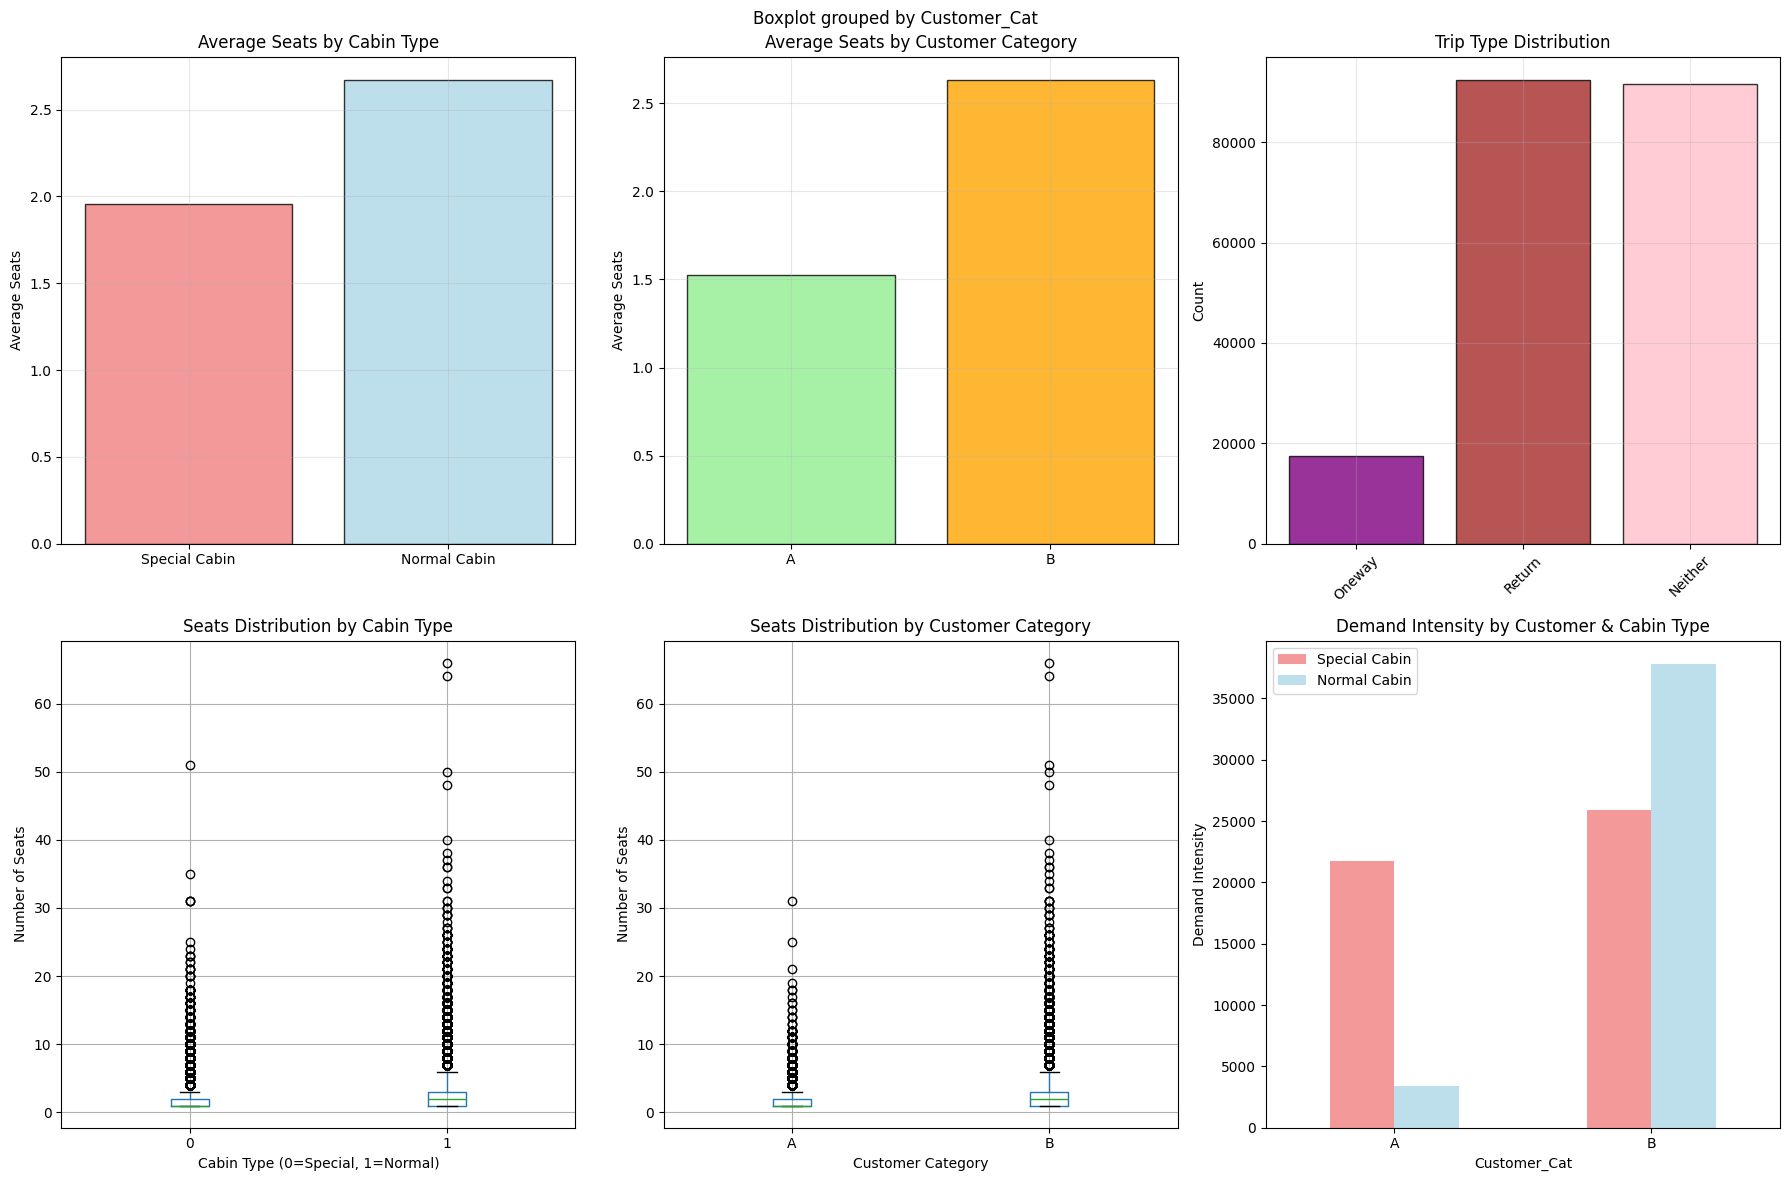

In [ ]:
print("Market Segmentation Analysis")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Market Segmentation Analysis', fontsize=16, fontweight='bold')

#Cabin Type
cabin_data = df.groupby('isNormCabin')['num_seats_total'].agg(['mean', 'count']).reset_index()
cabin_data['cabin_type'] = cabin_data['isNormCabin'].map({0: 'Special Cabin', 1: 'Normal Cabin'})

axes[0,0].bar(cabin_data['cabin_type'], cabin_data['mean'],
                  color=['lightcoral', 'lightblue'], alpha=0.8, edgecolor='black')
axes[0,0].set_title('Average Seats by Cabin Type')
axes[0,0].set_ylabel('Average Seats')
axes[0,0].grid(True, alpha=0.3)

#Customer Category
customer_data = df.groupby('Customer_Cat')['num_seats_total'].agg(['mean', 'count']).reset_index()

axes[0,1].bar(customer_data['Customer_Cat'], customer_data['mean'],
                  color=['lightgreen', 'orange'], alpha=0.8, edgecolor='black')
axes[0,1].set_title('Average Seats by Customer Category')
axes[0,1].set_ylabel('Average Seats')
axes[0,1].grid(True, alpha=0.3)

#Trip Type
trip_summary = pd.DataFrame({
        'trip_type': ['Oneway', 'Return', 'Neither'],
        'Count': [
            ((df['isOneway'] == 1) & (df['isReturn'] == 0)).sum(),
            ((df['isOneway'] == 0) & (df['isReturn'] == 1)).sum(),
            ((df['isOneway'] == 0) & (df['isReturn'] == 0)).sum()
        ]
    })

axes[0,2].bar(trip_summary['trip_type'], trip_summary['Count'],
                  color=['purple', 'brown', 'pink', 'gray'], alpha=0.8, edgecolor='black')
axes[0,2].set_title('Trip Type Distribution')
axes[0,2].set_ylabel('Count')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].grid(True, alpha=0.3)

#Box plots for a more detailed comparison
df.boxplot(column='num_seats_total', by='isNormCabin', ax=axes[1,0])
axes[1,0].set_title('Seats Distribution by Cabin Type')
axes[1,0].set_xlabel('Cabin Type (0=Special, 1=Normal)')
axes[1,0].set_ylabel('Number of Seats')

df.boxplot(column='num_seats_total', by='Customer_Cat', ax=axes[1,1])
axes[1,1].set_title('Seats Distribution by Customer Category')
axes[1,1].set_xlabel('Customer Category')
axes[1,1].set_ylabel('Number of Seats')

#Demand Intensity by customer segmentation
revenue_data = df.groupby(['Customer_Cat', 'isNormCabin'])['demand_intensity'].sum().reset_index()
revenue_pivot = revenue_data.pivot(index='Customer_Cat', columns='isNormCabin', values='demand_intensity')

revenue_pivot.plot(kind='bar', ax=axes[1,2], color=['lightcoral', 'lightblue'], alpha=0.8)
axes[1,2].set_title('Demand Intensity by Customer & Cabin Type')
axes[1,2].set_ylabel('Demand Intensity')
axes[1,2].legend(['Special Cabin', 'Normal Cabin'])
axes[1,2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig("market_segmentation_analysis.pdf", format="pdf")

plt.show()



Temporal Analysis


<Figure size 1400x800 with 0 Axes>

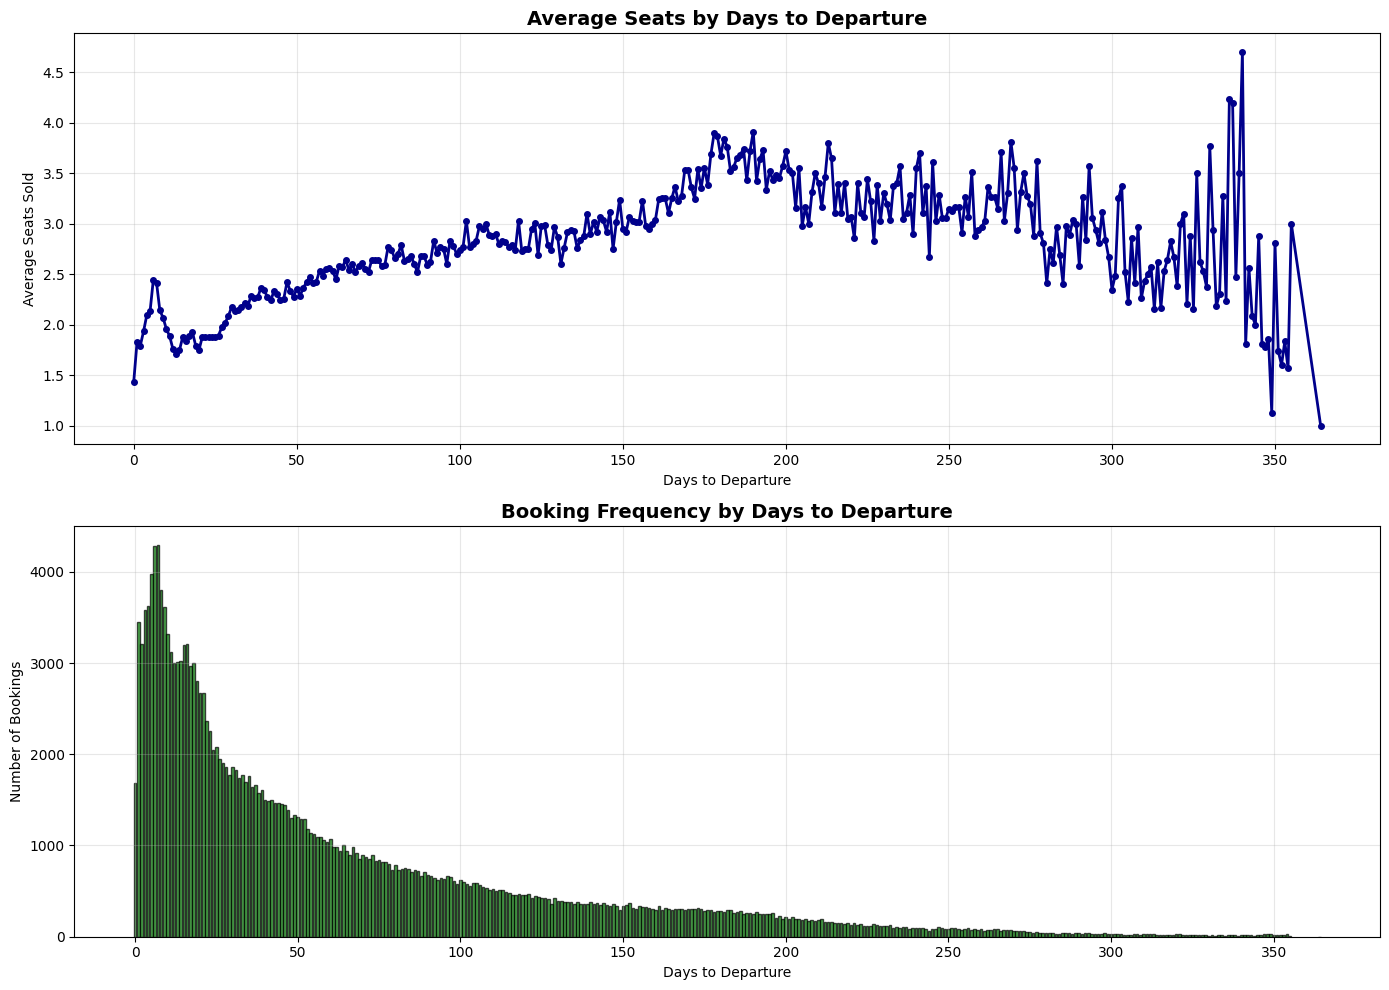

In [ ]:
#Time Series Analysis
print("Temporal Analysis")
if df['days_to_departure'].std() > 0:
        plt.figure(figsize=(14, 8))

#Group by days to departure and calculate mean seats
time_analysis = df.groupby('days_to_departure').agg({
            'num_seats_total': ['mean', 'count'],
            'mean_net_ticket_price': 'mean'
        }).reset_index()

time_analysis.columns = ['days_to_departure', 'avg_seats', 'count', 'avg_price']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

#Average seats by booking days to departure
ax1.plot(time_analysis['days_to_departure'], time_analysis['avg_seats'],
                marker='o', linewidth=2, markersize=4, color='darkblue')
ax1.set_title('Average Seats by Days to Departure', fontsize=14, fontweight='bold')
ax1.set_xlabel('Days to Departure')
ax1.set_ylabel('Average Seats Sold')
ax1.grid(True, alpha=0.3)

#Booking frequency
ax2.bar(time_analysis['days_to_departure'], time_analysis['count'],
               alpha=0.7, color='green', edgecolor='black')
ax2.set_title('Booking Frequency by Days to Departure', fontsize=14, fontweight='bold')
ax2.set_xlabel('Days to Departure')
ax2.set_ylabel('Number of Bookings')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("temporal_analysis.pdf", format="pdf")

plt.show()

Log-Transformed Analysis


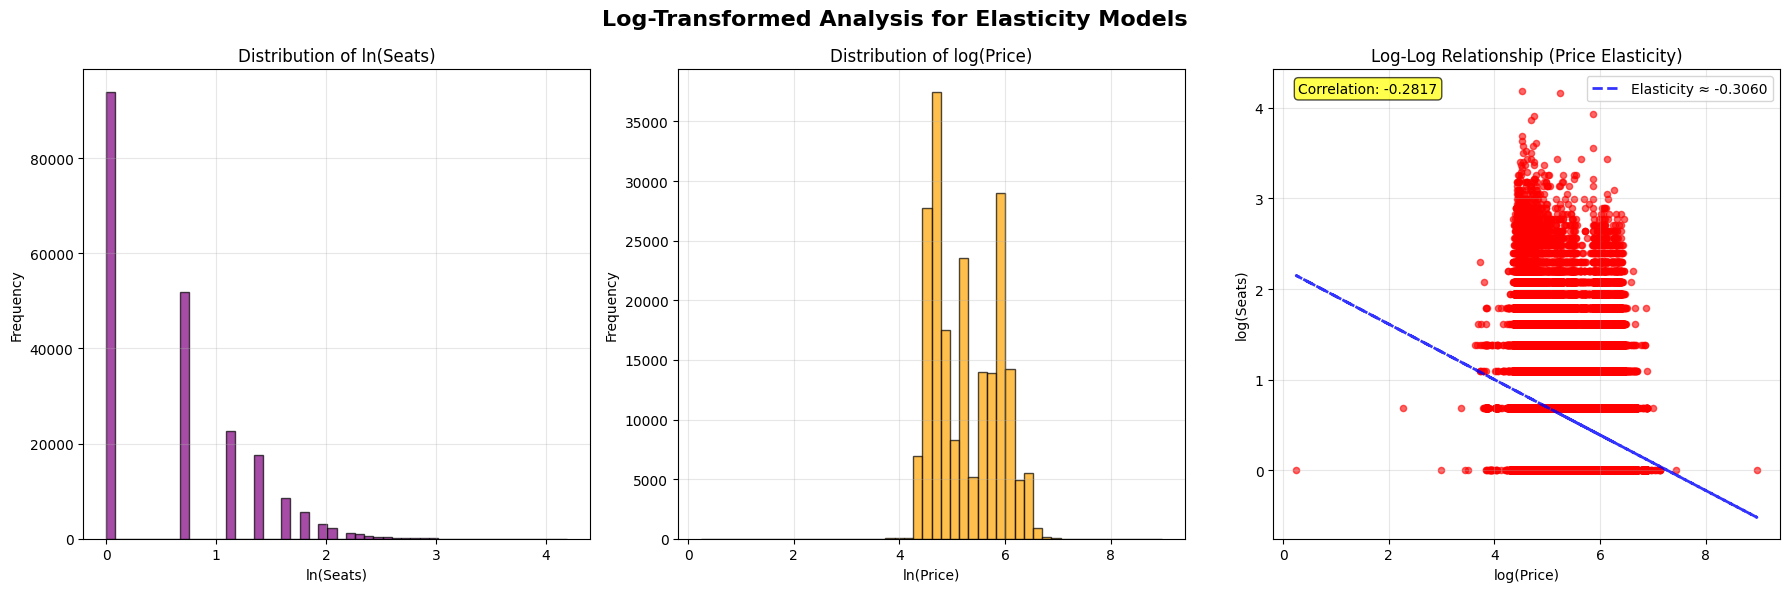

In [ ]:
#Log-Transformed Analysis
print("Log-Transformed Analysis")
if 'log_seats' in df.columns and 'log_price' in df.columns:
  fig, axes = plt.subplots(1, 3, figsize=(18, 6))
  fig.suptitle('Log-Transformed Analysis for Elasticity Models', fontsize=16, fontweight='bold')

  #Log-seats distribution
  axes[0].hist(df['log_seats'], bins=50, alpha=0.7, color='purple', edgecolor='black')
  axes[0].set_title('Distribution of ln(Seats)')
  axes[0].set_xlabel('ln(Seats)')
  axes[0].set_ylabel('Frequency')
  axes[0].grid(True, alpha=0.3)

  #Log-price distribution
  axes[1].hist(df['log_price'], bins=50, alpha=0.7, color='orange', edgecolor='black')
  axes[1].set_title('Distribution of log(Price)')
  axes[1].set_xlabel('ln(Price)')
  axes[1].set_ylabel('Frequency')
  axes[1].grid(True, alpha=0.3)

  #Log-log relationship (elasticity)
  if df['log_price'].std() > 0:
    axes[2].scatter(df['log_price'], df['log_seats'], alpha=0.6, c='red', s=20)

    #Add trend line
    z = np.polyfit(df['log_price'], df['log_seats'], 1)
    p = np.poly1d(z)
    axes[2].plot(df['log_price'], p(df['log_price']),
                          "b--", alpha=0.8, linewidth=2,
                          label=f'Elasticity ≈ {z[0]:.4f}')

    axes[2].set_xlabel('log(Price)')
    axes[2].set_ylabel('log(Seats)')
    axes[2].set_title('Log-Log Relationship (Price Elasticity)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    #Add correlation
    log_corr = df['log_price'].corr(df['log_seats'])
    axes[2].text(0.05, 0.95, f'Correlation: {log_corr:.4f}',
                          transform=axes[2].transAxes,
                          bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
  else:
    axes[2].text(0.5, 0.5, 'No price variation\nCannot estimate elasticity',
                          ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Log-Log Relationship (No Price Variation)')

plt.tight_layout()
plt.savefig("log_analysis.pdf", format="pdf")

plt.show()

In [ ]:
#Tables
import numpy as np, pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

def rmse_mae(y, yhat):
    y = np.asarray(y, float).ravel()
    yhat = np.asarray(yhat, float).ravel()
    return float(np.sqrt(np.mean((y-yhat)**2))), float(np.mean(np.abs(y-yhat)))

def elasticity_levels(beta_price, Pbar, Qbar):
    if any(np.isnan([beta_price, Pbar, Qbar])) or Qbar == 0:
        return np.nan
    return float(beta_price * Pbar / Qbar)

def poisson_pseudo_r2(po_res, df, y_col='num_seats_total'):
    # McFadden
    ll_full = float(po_res.llf)
    ll_null = float(smf.glm(f"{y_col} ~ 1", data=df, family=sm.families.Poisson()).fit().llf)
    mcf = 1 - (ll_full/ll_null) if ll_null != 0 else np.nan
    # McFadden adj
    k = po_res.df_model + 1  # includes intercept
    n = po_res.nobs
    mcf_adj = 1 - (ll_full - k) / ll_null if ll_null != 0 else np.nan
    # Deviance-based
    dev_full = float(po_res.deviance)
    dev_null = float(smf.glm(f"{y_col} ~ 1", data=df, family=sm.families.Poisson()).fit().deviance)
    dev_r2 = 1 - (dev_full/dev_null) if dev_null != 0 else np.nan
    return {"McFadden_R2": mcf, "McFadden_R2_adj": mcf_adj, "Deviance_R2": dev_r2}

rows = []

# ---------- OLS (levels) ----------
if 'm_ols' in globals():
    y = m_ols.model.endog
    yhat = m_ols.fittedvalues
    rmse, mae = rmse_mae(y, yhat)
    betaP = m_ols.params.get('mean_net_ticket_price', np.nan)
    Pbar  = float(np.mean(m_ols.model.data.frame['mean_net_ticket_price']))
    Qbar  = float(np.mean(m_ols.model.data.frame['num_seats_total']))
    rows.append({
        "model": "OLS (levels)",
        "type": "OLS",
        "nobs": float(m_ols.nobs),
        "R2": float(getattr(m_ols, "rsquared", np.nan)),
        "Adj_R2": float(getattr(m_ols, "rsquared_adj", np.nan)),
        "Pseudo_R2": np.nan,
        "RMSE": rmse,
        "MAE": mae,
        "AIC": float(getattr(m_ols, "aic", np.nan)),
        "BIC": float(getattr(m_ols, "bic", np.nan)),
        "Elasticity": elasticity_levels(betaP, Pbar, Qbar),
        "FirstStage_R2": np.nan,
        "FirstStage_F": np.nan,
        "FirstStage_PartialR2": np.nan
    })

# ---------- IV-2SLS (levels) — NO YM-FE ----------
if 'iv_res' in globals():
    y = iv_res.model.dependent.pandas.squeeze().to_numpy()
    yhat = iv_res.predict()
    rmse, mae = rmse_mae(y, yhat)
    df_iv = pd.concat(
        [iv_res.model.dependent.pandas,
         iv_res.model.exog.pandas,
         iv_res.model.endog.pandas,
         iv_res.model.instruments.pandas],
        axis=1
    )
    betaP = iv_res.params.get('mean_net_ticket_price', np.nan)
    Pbar  = float(df_iv['mean_net_ticket_price'].mean())
    Qbar  = float(df_iv['num_seats_total'].mean())
    # first stage via separate OLS if you saved it as fs_lvl
    fs_R2 = float(getattr(globals().get('fs_lvl', None), 'rsquared', np.nan))
    # rough partial R² and F for IV (if fs_lvl available)
    pR2 = np.nan; Fstat = np.nan
    if 'fs_lvl' in globals() and 'iv_price_loo' in fs_lvl.params.index:
        t = float(fs_lvl.tvalues['iv_price_loo']); Fstat = t*t
        pR2 = Fstat / (Fstat + float(fs_lvl.df_resid))
    rows.append({
        "model": "IV-2SLS (levels)",
        "type": "IV-2SLS",
        "nobs": float(iv_res.nobs),
        "R2": float(getattr(iv_res, "rsquared", np.nan)),
        "Adj_R2": np.nan,
        "Pseudo_R2": np.nan,
        "RMSE": rmse, "MAE": mae, "AIC": np.nan, "BIC": np.nan,
        "Elasticity": elasticity_levels(betaP, Pbar, Qbar),
        "FirstStage_R2": fs_R2, "FirstStage_F": Fstat, "FirstStage_PartialR2": pR2
    })

# ---------- IV-2SLS (levels) + YM-FE ----------
if 'iv_ymfe' in globals():
    y = iv_ymfe.model.dependent.pandas.squeeze().to_numpy()
    yhat = iv_ymfe.predict()
    rmse, mae = rmse_mae(y, yhat)
    df_ivfe = pd.concat(
        [iv_ymfe.model.dependent.pandas,
         iv_ymfe.model.exog.pandas,
         iv_ymfe.model.endog.pandas,
         iv_ymfe.model.instruments.pandas],
        axis=1
    )
    betaP = iv_ymfe.params.get('mean_net_ticket_price', np.nan)
    Pbar  = float(df_ivfe['mean_net_ticket_price'].mean())
    Qbar  = float(df_ivfe['num_seats_total'].mean())
    # first stage from fs_lvl or iv_ymfe.first_stage if you prefer (printing is easy, programmatic is fiddly)
    fs_R2 = float(getattr(globals().get('fs_lvl', None), 'rsquared', np.nan))
    pR2 = np.nan; Fstat = np.nan
    if 'fs_lvl' in globals() and 'iv_price_loo' in fs_lvl.params.index:
        t = float(fs_lvl.tvalues['iv_price_loo']); Fstat = t*t
        pR2 = Fstat / (Fstat + float(fs_lvl.df_resid))
    rows.append({
        "model": "IV-2SLS + YM-FE (levels)",
        "type": "IV-2SLS",
        "nobs": float(iv_ymfe.nobs),
        "R2": float(getattr(iv_ymfe, "rsquared", np.nan)),
        "Adj_R2": np.nan,
        "Pseudo_R2": np.nan,
        "RMSE": rmse, "MAE": mae, "AIC": np.nan, "BIC": np.nan,
        "Elasticity": elasticity_levels(betaP, Pbar, Qbar),
        "FirstStage_R2": fs_R2, "FirstStage_F": Fstat, "FirstStage_PartialR2": pR2
    })

# ---------- Poisson 2SRI (with YM-FE) ----------
if 'po_res' in globals():
    dfp = po_res.model.data.frame   # the dataframe used for Poisson fit
    y = dfp['num_seats_total'].to_numpy(float)
    mu_hat = po_res.predict(dfp)
    rmse, mae = rmse_mae(y, mu_hat)
    pse = poisson_pseudo_r2(po_res, dfp)
    log_price_coef = float(po_res.params.get('log_price', np.nan))  # elasticity in log-link
    fs_R2 = float(getattr(globals().get('fs_log', None), 'rsquared', np.nan))
    rows.append({
        "model": "Poisson 2SRI + YM-FE",
        "type": "GLM-Poisson (IV via CF)",
        "nobs": float(po_res.nobs),
        "R2": np.nan,
        "Adj_R2": np.nan,
        "Pseudo_R2": float(pse['McFadden_R2']),
        "RMSE": rmse, "MAE": mae,
        "AIC": float(po_res.aic), "BIC": np.nan,
        "Elasticity": log_price_coef,
        "FirstStage_R2": fs_R2, "FirstStage_F": np.nan, "FirstStage_PartialR2": np.nan
    })

# ---------- Make the table pretty ----------
summary_tbl = pd.DataFrame(rows)
# optional formatting example:
with pd.option_context('display.float_format', '{:,.4f}'.format):
    display(summary_tbl)
# save if you like:
# summary_tbl.to_csv("model_summary.csv", index=False)

,model,type,nobs,R2,Adj_R2,Pseudo_R2,RMSE,MAE,AIC,BIC,Elasticity,FirstStage_R2,FirstStage_F,FirstStage_PartialR2
0,IV-2SLS (levels),IV-2SLS,"209,690.0000",0.0532,NaN,NaN,2.0271,1.3749,NaN,NaN,-0.4722,NaN,NaN,NaN
1,IV-2SLS + YM-FE (levels),IV-2SLS,"209,690.0000",-0.1474,NaN,NaN,2.2316,1.5707,NaN,NaN,-1.2563,NaN,NaN,NaN
2,Poisson 2SRI + YM-FE,GLM-Poisson (IV via CF),"209,690.0000",NaN,NaN,0.0521,1.9630,1.2930,"769,215.8518",NaN,-0.9756,NaN,NaN,NaN


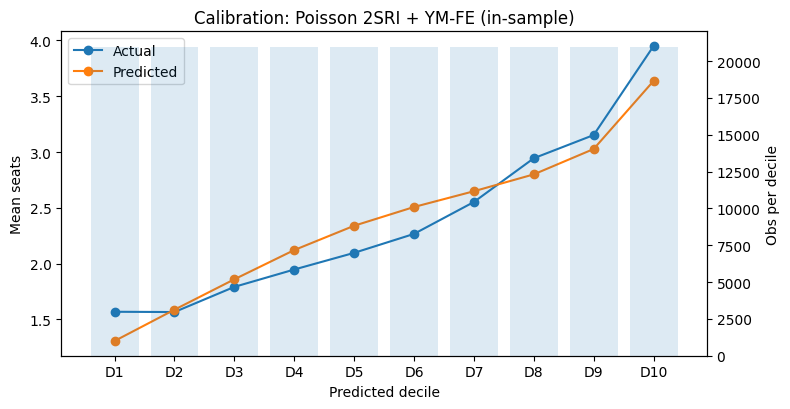

,decile,actual_mean,pred_mean,n,decile_num
0,"(0.603, 1.455]",1.568,1.306,20969,1
1,"(1.455, 1.723]",1.565,1.586,20969,2
2,"(1.723, 1.995]",1.791,1.859,20969,3
3,"(1.995, 2.24]",1.947,2.121,20969,4
4,"(2.24, 2.43]",2.096,2.339,20969,5
5,"(2.43, 2.58]",2.266,2.507,20969,6
6,"(2.58, 2.716]",2.552,2.648,20969,7
7,"(2.716, 2.896]",2.944,2.800,20969,8
8,"(2.896, 3.185]",3.152,3.027,20969,9
9,"(3.185, 83.134]",3.950,3.637,20969,10


In [ ]:
#Decile-plot
import matplotlib.pyplot as plt

def calibration_deciles(y, yhat, q=10, title="Calibration: Poisson 2SRI + YM-FE", save_as=None):
    cal = pd.DataFrame({"actual": np.asarray(y,float), "pred": np.asarray(yhat,float)})
    cal = cal.replace([np.inf,-np.inf], np.nan).dropna()
    cal["decile"] = pd.qcut(cal["pred"], q=q, duplicates="drop")
    summ = (cal.groupby("decile", observed=True)
              .agg(actual_mean=("actual","mean"),
                   pred_mean  =("pred","mean"),
                   n          =("actual","size"))
              .reset_index())
    # order left→right
    summ["decile_num"] = summ["decile"].cat.codes + 1
    summ = summ.sort_values("decile_num").reset_index(drop=True)

    # --- plot ---
    x = summ["decile_num"].to_numpy()
    fig, ax = plt.subplots(figsize=(8,4.2))
    ax.plot(x, summ["actual_mean"], marker="o", label="Actual")
    ax.plot(x, summ["pred_mean"],   marker="o", label="Predicted")
    ax.set_xticks(x); ax.set_xticklabels([f"D{i}" for i in x])
    ax.set_xlabel("Predicted decile"); ax.set_ylabel("Mean seats")
    ax.set_title(title); ax.legend()
    ax2 = ax.twinx()
    ax2.bar(x, summ["n"], alpha=0.15)
    ax2.set_ylabel("Obs per decile")
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, dpi=200, bbox_inches="tight")
    plt.show()
    return summ

# use with your Poisson fit:
if 'po_res' in globals():
    dfp = po_res.model.data.frame
    y = dfp['num_seats_total'].to_numpy(float)
    mu_hat = po_res.predict(dfp)
    decile_tbl = calibration_deciles(y, mu_hat, q=10,
                                     title="Calibration: Poisson 2SRI + YM-FE (in-sample)",
                                     save_as="cal_poisson2sri.png")
    with pd.option_context('display.float_format','{:,.3f}'.format):
        display(decile_tbl)
    # decile_tbl.to_csv("calibration_deciles_poisson.csv", index=False)


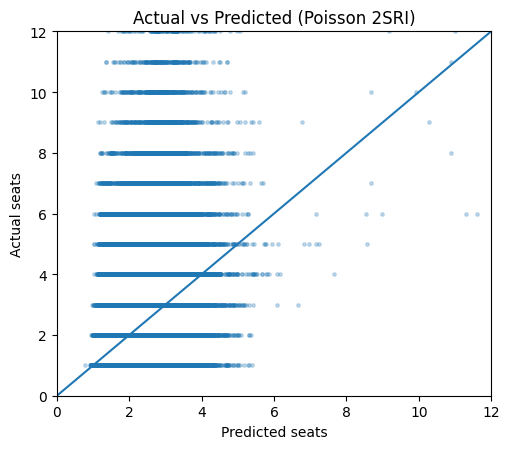

In [ ]:
#Actual vs Predicted Poisson
def scatter_actual_vs_pred(y, yhat, sample=50_000, title="Actual vs Predicted (Poisson 2SRI)"):
    y = np.asarray(y,float).ravel()
    yhat = np.asarray(yhat,float).ravel()
    n = len(y)
    if n > sample:
        idx = np.random.RandomState(42).choice(n, size=sample, replace=False)
        y, yhat = y[idx], yhat[idx]
    plt.figure(figsize=(5.2,4.6))
    plt.scatter(yhat, y, alpha=0.25, s=6)
    lim = (0, max(np.percentile(y, 99.5), np.percentile(yhat, 99.5)))
    plt.plot(lim, lim)     # 45° line
    plt.xlim(lim); plt.ylim(lim)
    plt.xlabel("Predicted seats"); plt.ylabel("Actual seats")
    plt.title(title)
    plt.tight_layout(); plt.show()

if 'po_res' in globals():
    dfp = po_res.model.data.frame
    y = dfp['num_seats_total'].to_numpy(float)
    mu_hat = po_res.predict(dfp)
    scatter_actual_vs_pred(y, mu_hat, sample=60_000)

In [ ]:
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float).ravel()
    y_pred = np.asarray(y_pred, float).ravel()
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, float).ravel()
    y_pred = np.asarray(y_pred, float).ravel()
    return float(np.mean(np.abs(y_true - y_pred)))

# Split data into train and test sets
if "Dept_Date" in df.columns and df["Dept_Date"].notna().any():
    df_sorted = df.sort_values("Dept_Date")
    cutoff = int(len(df_sorted) * 0.8)
    train = df_sorted.iloc[:cutoff].copy()
    test  = df_sorted.iloc[cutoff:].copy()
else:
    train = df.sample(frac=0.8, random_state=42).copy()
    test  = df.drop(train.index).copy()

# Ensure necessary columns for first stage and second stage are present in both train and test
needed_cols = ["num_seats_total", "log_price", "mean_net_ticket_price", "days_to_departure",
               "isNormCabin", "isReturn", "isOneway", "Customer_Cat", "ym", "iv_price_loo", "demand_intensity", "trip_type", "CabinType"]

for col in needed_cols:
    if col not in train.columns:
        print(f"Warning: '{col}' not found in training data.")
    if col not in test.columns:
        print(f"Warning: '{col}' not found in testing data.")

train = train.dropna(subset=[c for c in needed_cols if c in train.columns])
test  = test.dropna(subset=[c for c in needed_cols if c in test.columns])

# First stage: price regression to get residuals (rhat)
fs_form = (
    "log_price ~ lnIV + days_to_departure "
    "+ C(trip_type , Treatment('Neither')) "
    "+ C(CabinType, Treatment('Special')) + C(Customer_Cat) + C(ym)"
)

# Ensure lnIV is available or create it if needed for the first stage
if 'lnIV' not in train.columns:
     if 'iv_price_loo' in train.columns:
         train['lnIV'] = np.log(train['iv_price_loo'].clip(lower=1e-6))
     else:
         print("Warning: 'lnIV' and 'iv_price_loo' not found in training data. Cannot fit first stage.")
         fs_form = "log_price ~ days_to_departure + C(trip_type , Treatment('Neither')) + C(CabinType, Treatment('Special')) + C(Customer_Cat) + C(ym)" # Fallback formula

if 'lnIV' not in test.columns:
     if 'iv_price_loo' in test.columns:
         test['lnIV'] = np.log(test['iv_price_loo'].clip(lower=1e-6))
     else:
         print("Warning: 'lnIV' and 'iv_price_loo' not found in testing data.")


if 'lnIV' in train.columns:
    fs = smf.ols(fs_form, data=train).fit(cov_type="HC3")
    train["rhat"] = fs.resid
    test["rhat"] = fs.predict(test) - test["log_price"] # Calculate residual for test set
else:
    train['rhat'] = 0 # Set rhat to 0 if first stage cannot be run
    test['rhat'] = 0


models_fitted = {}
comparison_rows = []

# Define formula_log if it's not in the current scope
if 'formula_log' not in globals():
    formula_log = "log_seats ~ log_price + np.log(days_to_departure + 1) + isNormCabin + isReturn + isOneway + Train_Number_All + Customer_Cat"
    if 'log_seats' not in train.columns:
        train['log_seats'] = np.log(train['num_seats_total'].clip(lower=1))
    if 'log_seats' not in test.columns:
        test['log_seats'] = np.log(test['num_seats_total'].clip(lower=1))


# Second stage models
po_form = (
    "num_seats_total ~ log_price + rhat + demand_intensity +  days_to_departure "
    "+ C(trip_type, Treatment('Neither')) "
    "+ C(CabinType, Treatment('Special')) + C(Customer_Cat) + C(ym)"
)

poisson = smf.glm(formula=po_form, data=train, family=sm.families.Poisson()).fit()
models_fitted["Poisson"] = poisson
test["pred_poisson"] = poisson.predict(test)
comparison_rows.append({
    "model": "Poisson",
    "AIC": poisson.aic,
    "BIC": getattr(poisson, "bic", np.nan),
    "RMSE_test": rmse(test["num_seats_total"], test["pred_poisson"]),
    "MAE_test": mae(test["num_seats_total"], test["pred_poisson"]),
})

try:
    nb = smf.glm(formula=po_form, data=train, family=sm.families.NegativeBinomial()).fit()
    models_fitted["NegBin"] = nb
    test["pred_nb"] = nb.predict(test)
    comparison_rows.append({
        "model": "NegBin",
        "AIC": nb.aic,
        "BIC": getattr(nb, "bic", np.nan),
        "RMSE_test": rmse(test["num_seats_total"], test["pred_nb"]),
        "MAE_test": mae(test["num_seats_total"], test["pred_nb"]),
    })
except Exception as e:
    print("NegBin model could not be fit:", e)
    nb = None # Ensure nb is None if fitting fails

log_model1 = smf.ols(formula=formula_log, data=train).fit()
models_fitted["OLS_log"] = log_model1
sigma2 = np.var(log_model1.resid, ddof=int(log_model1.df_model) + 1)
test["_ols_linpred"] = log_model1.predict(test)
test["pred_ols_backtrans"] = np.exp(test["_ols_linpred"] + 0.5 * sigma2) - 1.0
comparison_rows.append({
    "model": "OLS_log(→counts)",
    "AIC": log_model1.aic,
    "BIC": log_model1.bic,
    "RMSE_test": rmse(test["num_seats_total"], test["pred_ols_backtrans"]),
    "MAE_test": mae(test["num_seats_total"], test["pred_ols_backtrans"]),
})

comparison_df = pd.DataFrame(comparison_rows).sort_values(["RMSE_test", "AIC"]).reset_index(drop=True)

final = models_fitted.get("Poisson", None) or models_fitted.get("NegBin", None) or models_fitted.get("OLS_log", None)

if final:
    coef_table = final.summary2().tables[1].reset_index().rename(columns={"index": "term"})
    coef_table.rename(columns={"Coef.": "coef", "Std.Err.": "std_err", "P>|z|": "p_value"}, inplace=True, errors="ignore")

    # Price elasticity
    if "log_price" in coef_table["term"].values:
        price_elasticity = float(coef_table.loc[coef_table["term"] == "log_price", "coef"].iloc[0])
        elasticity_note = f"Price elasticity (log-log) = {price_elasticity:.3f}"
    elif "mean_net_ticket_price" in coef_table["term"].values:
        beta = float(coef_table.loc[coef_table["term"] == "mean_net_ticket_price", "coef"].iloc[0])
        pbar = float(df["mean_net_ticket_price"].mean())
        price_elasticity = beta * pbar
        elasticity_note = f"Price elasticity at mean price (semi-log) ≈ {price_elasticity:.3f} (beta={beta:.4f}, mean price={pbar:.3f})"
    else:
        price_elasticity = np.nan
        elasticity_note = "Price elasticity not available (price term missing)."

    print("\nModel Comparison:")
    display(comparison_df)
    print("\nFinal Model Coefficients:")
    display(coef_table)
    print("\nElasticity Note:")
    print(elasticity_note)
else:
    print("No models were successfully fitted.")


Model Comparison:


,model,AIC,BIC,RMSE_test,MAE_test
0,OLS_log(→counts),310273.944558,3.104745e+05,2.559308,1.486608
1,NegBin,670783.010999,-1.969931e+06,3.923124,2.291156
2,Poisson,604352.696508,-1.838962e+06,4.167794,2.423314



Final Model Coefficients:


,term,coef,std_err,z,p_value,[0.025,0.975]
0,Intercept,7.108393e+00,1.733512e-01,41.005727,0.000000e+00,6.768631e+00,7.448155e+00
1,"C(trip_type, Treatment('Neither'))[T.Oneway]",1.562924e-03,6.787160e-03,0.230277,8.178769e-01,-1.173967e-02,1.486551e-02
2,"C(trip_type, Treatment('Neither'))[T.Return]",3.563951e-02,3.635122e-03,9.804212,1.079864e-22,2.851480e-02,4.276421e-02
3,"C(CabinType, Treatment('Special'))[T.Normal]",-5.577039e-01,1.812927e-02,-30.762626,8.289314e-208,-5.932366e-01,-5.221712e-01
4,C(Customer_Cat)[T.B],1.788895e-01,7.315902e-03,24.452149,4.774387e-132,1.645506e-01,1.932284e-01
5,C(ym)[T.2018-07],-2.573682e-01,1.485588e-02,-17.324329,3.082690e-67,-2.864851e-01,-2.282512e-01
6,C(ym)[T.2018-08],-2.778163e-01,1.459188e-02,-19.039108,8.089394e-81,-3.064159e-01,-2.492168e-01
7,C(ym)[T.2018-09],-3.866505e-01,1.520355e-02,-25.431592,1.128439e-142,-4.164490e-01,-3.568521e-01
8,C(ym)[T.2018-10],-3.491256e-01,1.480869e-02,-23.575729,6.839105e-123,-3.781501e-01,-3.201011e-01
9,C(ym)[T.2018-11],-1.337410e-01,1.321429e-02,-10.120938,4.461210e-24,-1.596406e-01,-1.078415e-01



Elasticity Note:
Price elasticity (log-log) = -1.109


In [ ]:
rhs_terms = [
    "log_price",
    "isNormCabin",
    "isReturn",
    "isOneway",
    "Customer_Cat",
    "days_to_departure"
]

In [ ]:
y = "num_seats_total"
poisson_final = smf.glm(formula=po_form,
                        data=train,
                        family=sm.families.Poisson()).fit()

print(poisson_final.summary())

coef_table = poisson_final.summary2().tables[1].reset_index()
coef_table.rename(columns={"index": "term",
                           "Coef.": "coef",
                           "Std.Err.": "std_err",
                           "P>|z|": "p_value"}, inplace=True, errors="ignore")

if "log_price" in coef_table["term"].values:
    elasticity = coef_table.loc[coef_table["term"]=="log_price","coef"].iloc[0]
    print(f"Price elasticity of demand = {elasticity:.3f}")
elif "mean_net_ticket_price" in coef_table["term"].values:
    beta = coef_table.loc[coef_table["term"]=="mean_net_ticket_price","coef"].iloc[0]
    pbar = df["mean_net_ticket_price"].mean()
    elasticity = beta * pbar
    print(f"Semi-elasticity at mean price ≈ {elasticity:.3f}")
else:
    print("No price term found → cannot compute elasticity.")

def predict_poisson(new_df: pd.DataFrame) -> np.ndarray:
    """
    Predict demand (expected seats sold) using the fitted Poisson model.
    If log_price is required but not provided, it will be computed.
    """
    if "log_price" in rhs_terms and "log_price" not in new_df.columns \
       and "mean_net_ticket_price" in new_df.columns:
        new_df = new_df.copy()
        new_df["log_price"] = np.log(new_df["mean_net_ticket_price"])
    return poisson_final.predict(new_df)

base = {}
if "mean_net_ticket_price" in df.columns:
    base["mean_net_ticket_price"] = df["mean_net_ticket_price"].mean()
if "isNormCabin" in df.columns:
    base["isNormCabin"] = round(df["isNormCabin"].fillna(0).mean())
if "isReturn" in df.columns:
    base["isReturn"] = round(df["isReturn"].fillna(0).mean())
if "isOneway" in df.columns:
    base["isOneway"] = round(df["isOneway"].fillna(0).mean())
if "days_to_departure" in df.columns and df["days_to_departure"].notna().any():
    base["days_to_departure"] = float(df["days_to_departure"].median())
if "Customer_Cat" in df.columns and not df["Customer_Cat"].dropna().empty:
    base["Customer_Cat"] = df["Customer_Cat"].mode(dropna=True).iloc[0]

base_df = pd.DataFrame([base])


                 Generalized Linear Model Regression Results                  
Dep. Variable:        num_seats_total   No. Observations:               167756
Model:                            GLM   Df Residuals:                   167735
Model Family:                 Poisson   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.0216e+05
Date:                Sat, 20 Sep 2025   Deviance:                   1.7893e+05
Time:                        03:40:04   Pearson chi2:                 2.43e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1631
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
# === Summary table builder for OLS / IV-2SLS / GLM (Poisson) ===
import numpy as np, pandas as pd

def _get_attr_safe(obj, name, default=np.nan):
    try:
        val = getattr(obj, name)
        # handle callables like conf_int()
        return val() if callable(val) else val
    except Exception:
        return default

def _coef_pack_sm(res, param):
    """statsmodels or linearmodels-like: return (coef, se, p, (lo,hi))."""
    coef = np.nan; se = np.nan; p = np.nan; ci = (np.nan, np.nan)
    try:
        coef = float(res.params[param])
    except Exception:
        # fallback: try rough matching
        cand = [k for k in res.params.index if param in str(k)]
        if cand:
            coef = float(res.params[cand[0]])
            param = cand[0]
    try:
        se   = float((getattr(res, "bse", getattr(res, "std_errors")))[param])
    except Exception:
        pass
    try:
        p    = float(res.pvalues[param])
    except Exception:
        pass
    try:
        ci_df = res.conf_int()
        lo, hi = [float(x) for x in ci_df.loc[param].to_numpy()]
        ci = (lo, hi)
    except Exception:
        pass
    return coef, se, p, ci

def _guess_fit_stat(res, extras=None):
    """Prefer R² for OLS/IV; PseudoR² for GLM if supplied."""
    if extras and "pseudo_r2" in extras and np.isfinite(extras["pseudo_r2"]):
        return ("PseudoR²", float(extras["pseudo_r2"]))
    # linearmodels IV has rsquared; statsmodels OLS has rsquared
    r2 = _get_attr_safe(res, "rsquared")
    if isinstance(r2, (float, int)) and np.isfinite(r2):
        return ("R²", float(r2))
    # try centered R²
    r2c = _get_attr_safe(res, "rsquared_centered")
    if isinstance(r2c, (float, int)) and np.isfinite(r2c):
        return ("R² (centered)", float(r2c))
    # try GLM loglik / AIC as fallback display
    aic = _get_attr_safe(res, "aic")
    if isinstance(aic, (float, int)) and np.isfinite(aic):
        return ("AIC", float(aic))
    return ("Fit", np.nan)

def _model_kind(res):
    t = type(res).__name__.lower()
    if "iv2sls" in t or "ivgmm" in t or "ivliml" in t:
        return "IV-2SLS/IV"
    if "glm" in t:
        return "GLM"
    if "regressionresults" in t or "ols" in t:
        return "OLS"
    return type(res).__name__

def add_model_row(name, res, price_vars, outcome,
                  iv_used=None, clusters_count=None, extras=None):
    """
    price_vars: list of candidate coefficient names, e.g. ["log_price","lnP","mean_net_ticket_price"]
    extras: dict of optional fields you computed elsewhere:
        {"fs_r2":..., "fs_t":..., "partial_r2":..., "wald":..., "note":..., "elasticity_note":...,
         "n_obs_override":..., "pseudo_r2":...}
    """
    extras = extras or {}
    # find the first present price term
    present = None
    for p in price_vars:
        try:
            if p in res.params.index:
                present = p; break
        except Exception:
            pass
    if present is None:
        # last-resort: try substring match
        try:
            for p in price_vars:
                cand = [k for k in getattr(res, "params").index if p in str(k)]
                if cand:
                    present = cand[0]; break
        except Exception:
            present = price_vars[0]  # just to avoid key errors

    coef, se, pval, ci = _coef_pack_sm(res, present)
    fit_name, fit_val  = _guess_fit_stat(res, extras)

    # N and clusters
    nobs = extras.get("n_obs_override", _get_attr_safe(res, "nobs"))
    # many statsmodels objects store nobs as numpy scalar; coerce
    try:
        nobs = int(nobs)
    except Exception:
        nobs = np.nan

    row = {
        "Model": name,
        "Method": _model_kind(res),
        "Outcome": outcome,
        "Price term": str(present),
        "Price effect": coef,
        "SE": se,
        "95% CI": ci,
        "p-value": pval,
        fit_name: fit_val,
        "N": nobs,
        "Clusters": clusters_count if clusters_count is not None else np.nan,
        "IV": iv_used or "",
        "FS R²": extras.get("fs_r2", np.nan),
        "FS t(IV)": extras.get("fs_t", np.nan),
        "FS partial R²": extras.get("partial_r2", np.nan),
        "Wald ratio": extras.get("wald", np.nan),
        "Notes": extras.get("note", ""),
    }
    # add an interpretation marker
    if present in ("log_price","lnP","lnp","log(price)"):
        row["Interpretation"] = "Elasticity (log–log)"
    else:
        row["Interpretation"] = "Slope (level model)"

    return row

# ---------------------- Build your table ----------------------
rows = []

# A) OLS (levels)
rows.append(add_model_row(
    name="OLS (levels)",
    res=ols_model1,
    price_vars=["mean_net_ticket_price", "price", "P"],
    outcome="num_seats_total",
    iv_used=None, clusters_count=None,
    extras={}
))

# B) OLS (log–log)
rows.append(add_model_row(
    name="OLS (log–log)",
    res=log_model1,
    price_vars=["log_price","lnP","lnp","log(mean_net_ticket_price)"],
    outcome="log_seats",
    extras={}
))

# C) IV-2SLS (levels)
rows.append(add_model_row(
    name="IV-2SLS (levels)",
    res=iv_res_cl,
    price_vars=["mean_net_ticket_price","price","P"],
    outcome="num_seats_total",
    iv_used="iv_price_loo",
    clusters_count=globals().get("ivdf", pd.DataFrame()).get("Train_Number_All", pd.Series(dtype=object)).nunique(),
    extras={}
))

# D) IV-2SLS + YM FE (levels)
rows.append(add_model_row(
    name="IV-2SLS + YM FE (levels)",
    res=iv_ymfe_cl,
    price_vars=["mean_net_ticket_price"],
    outcome="num_seats_total",
    iv_used="iv_price_loo",
    clusters_count=globals().get("ivdf", pd.DataFrame()).get("Train_Number_All", pd.Series(dtype=object)).nunique(),
))

# E) IV-2SLS (log–log, pooled)
rows.append(add_model_row(
    name="IV-2SLS (log–log, pooled)",
    res=iv2,
    price_vars=["log_price","lnP","lnp"],
    outcome="lnQ",
    iv_used="lnIV",
    clusters_count=globals().get("ivdf", pd.DataFrame()).get("Train_Number_All", pd.Series(dtype=object)).nunique(),
    extras={"partial_r2": globals().get("partial_R2", np.nan)}
))

# F) IV-2SLS (log–log, ym×cabin FE)
# requires: variables fs (first-stage), wald, clusters (Series) created in your code above
rows.append(add_model_row(
    name="IV-2SLS (log–log, ym×cabin FE)",
    res=iv3,
    price_vars=["log_price","lnP","lnp"],
    outcome="lnQ",
    iv_used="lnIV_cabin",
    clusters_count=globals().get("clusters", pd.Series(dtype=object)).nunique() if "clusters" in globals() else np.nan,
    extras={
        "fs_r2": _get_attr_safe(globals().get("fs", None), "rsquared"),
        "fs_t": (globals().get("fs").tvalues.get("lnIV_cabin")
                 if "fs" in globals() and hasattr(globals()["fs"], "tvalues") else np.nan),
        "partial_r2": globals().get("partial_R2", np.nan),
        "wald": globals().get("wald", np.nan)
    }
))

# G) IV-2SLS (log–log, aggregated market)
# requires: iv4, rf, fs, wald, clusters (your prior code computes these)
rows.append(add_model_row(
    name="IV-2SLS (log–log, aggregated market)",
    res=iv4,
    price_vars=["log_price","lnP","lnp"],
    outcome="lnQ",
    iv_used="lnIV",
    clusters_count=globals().get("clusters", pd.Series(dtype=object)).nunique() if "clusters" in globals() else np.nan,
    extras={
        "fs_r2": _get_attr_safe(globals().get("fs", None), "rsquared"),
        "fs_t": (globals().get("fs").tvalues.get("lnIV")
                 if "fs" in globals() and hasattr(globals()["fs"], "tvalues") else np.nan),
        "wald": globals().get("wald", np.nan)
    }
))

# H) IV-2SLS (log–log, aggregated market – Normal only)
rows.append(add_model_row(
    name="IV-2SLS (log–log, aggregated, Normal only)",
    res=iv5,
    price_vars=["log_price","lnP","lnp"],
    outcome="lnQ",
    iv_used="lnIV",
    clusters_count=globals().get("clusters", pd.Series(dtype=object)).nunique() if "clusters" in globals() else np.nan,
    extras={
        "fs_r2": _get_attr_safe(globals().get("fs", None), "rsquared"),
        "fs_t": (globals().get("fs").tvalues.get("lnIV")
                 if "fs" in globals() and hasattr(globals()["fs"], "tvalues") else np.nan),
        "wald": globals().get("wald", np.nan)
    }
))

# I) Poisson IV 2SRI (log link)
# requires: po_res (GLMResults), pseudo_r2 you computed above
rows.append(add_model_row(
    name="Poisson IV 2SRI (log-link)",
    res=po_res,
    price_vars=["log_price","lnP","lnp"],
    outcome="num_seats_total",
    iv_used="lnIV (control-function)",
    clusters_count=globals().get("dfp", pd.DataFrame()).get("Train_Number_All", pd.Series(dtype=object)).nunique(),
    extras={"pseudo_r2": globals().get("pseudo_r2", np.nan)}
))

summary_df = pd.DataFrame(rows)

# Order columns nicely
col_order = [
    "Model","Method","Outcome","Price term","Interpretation",
    "Price effect","SE","95% CI","p-value",
    "R²","R² (centered)","AIC","PseudoR²",  # whichever exists will be filled by _guess_fit_stat
    "N","Clusters","IV","FS R²","FS partial R²","FS t(IV)","Wald ratio","Notes"
]
# Keep only columns that exist
col_order = [c for c in col_order if c in summary_df.columns]
summary_df = summary_df[col_order]

# Pretty-print CI and round
def _fmt_ci(ci):
    try:
        lo, hi = ci
        return f"[{lo:.3f}, {hi:.3f}]"
    except Exception:
        return ""

out = summary_df.copy()
if "Price effect" in out: out["Price effect"] = out["Price effect"].astype(float).round(4)
if "SE" in out: out["SE"] = out["SE"].astype(float).round(4)
if "p-value" in out: out["p-value"] = out["p-value"].astype(float).round(4)
if "95% CI" in out: out["95% CI"] = out["95% CI"].apply(_fmt_ci)
for c in ["R²","R² (centered)","AIC","PseudoR²","FS R²","FS partial R²","FS t(IV)","Wald ratio"]:
    if c in out:
        out[c] = pd.to_numeric(out[c], errors="coerce").round(3)

# Show and save
from IPython.display import display
display(out)
out.to_csv("model_summary_table.csv", index=False)
print("Saved to model_summary_table.csv")


,Model,Method,Outcome,Price term,Interpretation,Price effect,SE,95% CI,p-value,R²,PseudoR²,N,Clusters,IV,FS R²,FS partial R²,FS t(IV),Wald ratio,Notes
0,OLS (levels),OLS,num_seats_total,mean_net_ticket_price,Slope (level model),-0.0005,NaN,"[-0.001, -0.000]",0.0000,0.085,NaN,209697,NaN,,NaN,NaN,NaN,NaN,
1,OLS (log–log),OLS,log_seats,log_price,Elasticity (log–log),-0.1807,NaN,"[-0.188, -0.173]",0.0000,0.127,NaN,209697,NaN,,NaN,NaN,NaN,NaN,
2,IV-2SLS (levels),IVResults,num_seats_total,mean_net_ticket_price,Slope (level model),-0.0049,0.0017,"[-0.008, -0.002]",0.0032,0.053,NaN,209690,15.0,iv_price_loo,NaN,NaN,NaN,NaN,
3,IV-2SLS + YM FE (levels),IVResults,num_seats_total,mean_net_ticket_price,Slope (level model),-0.0130,0.0046,"[-0.022, -0.004]",0.0043,-0.147,NaN,209690,15.0,iv_price_loo,NaN,NaN,NaN,NaN,
4,"IV-2SLS (log–log, pooled)",IVResults,lnQ,log_price,Elasticity (log–log),-0.0095,0.0059,"[-0.021, 0.002]",0.1108,0.547,NaN,209690,15.0,lnIV,NaN,0.054,NaN,NaN,
5,"IV-2SLS (log–log, ym×cabin FE)",IVResults,lnQ,log_price,Elasticity (log–log),-0.0453,0.0068,"[-0.059, -0.032]",0.0000,0.557,NaN,209697,326.0,lnIV_cabin,0.668,0.054,NaN,-1.747,
6,"IV-2SLS (log–log, aggregated market)",IVResults,lnQ,log_price,Elasticity (log–log),-1.1421,0.1902,"[-1.515, -0.769]",0.0000,0.524,NaN,15076,326.0,lnIV,0.668,NaN,97.002,-1.747,
7,"IV-2SLS (log–log, aggregated, Normal only)",IVResults,lnQ,log_price,Elasticity (log–log),-1.7471,0.3283,"[-2.391, -1.104]",0.0000,0.676,NaN,7788,326.0,lnIV,0.668,NaN,97.002,-1.747,
8,Poisson IV 2SRI (log-link),GLM,num_seats_total,log_price,Elasticity (log–log),-0.9756,NaN,"[-1.466, -0.485]",0.0001,NaN,0.052,209690,14.0,lnIV (control-function),NaN,NaN,NaN,NaN,


Saved to model_summary_table.csv


In [ ]:
# Drop unwanted columns from the output table
drop_cols = ["FS R²", "FS partial R²", "FS t(IV)", "Wald ratio", "Notes"]
out = out.drop(columns=[c for c in drop_cols if c in out.columns])
out

,Model,Method,Outcome,Price term,Interpretation,Price effect,SE,95% CI,p-value,R²,PseudoR²,N,Clusters,IV
0,OLS (levels),OLS,num_seats_total,mean_net_ticket_price,Slope (level model),-0.0005,NaN,"[-0.001, -0.000]",0.0000,0.085,NaN,209697,NaN,
1,OLS (log–log),OLS,log_seats,log_price,Elasticity (log–log),-0.1807,NaN,"[-0.188, -0.173]",0.0000,0.127,NaN,209697,NaN,
2,IV-2SLS (levels),IVResults,num_seats_total,mean_net_ticket_price,Slope (level model),-0.0049,0.0017,"[-0.008, -0.002]",0.0032,0.053,NaN,209690,15.0,iv_price_loo
3,IV-2SLS + YM FE (levels),IVResults,num_seats_total,mean_net_ticket_price,Slope (level model),-0.0130,0.0046,"[-0.022, -0.004]",0.0043,-0.147,NaN,209690,15.0,iv_price_loo
4,"IV-2SLS (log–log, pooled)",IVResults,lnQ,log_price,Elasticity (log–log),-0.0095,0.0059,"[-0.021, 0.002]",0.1108,0.547,NaN,209690,15.0,lnIV
5,"IV-2SLS (log–log, ym×cabin FE)",IVResults,lnQ,log_price,Elasticity (log–log),-0.0453,0.0068,"[-0.059, -0.032]",0.0000,0.557,NaN,209697,326.0,lnIV_cabin
6,"IV-2SLS (log–log, aggregated market)",IVResults,lnQ,log_price,Elasticity (log–log),-1.1421,0.1902,"[-1.515, -0.769]",0.0000,0.524,NaN,15076,326.0,lnIV
7,"IV-2SLS (log–log, aggregated, Normal only)",IVResults,lnQ,log_price,Elasticity (log–log),-1.7471,0.3283,"[-2.391, -1.104]",0.0000,0.676,NaN,7788,326.0,lnIV
8,Poisson IV 2SRI (log-link),GLM,num_seats_total,log_price,Elasticity (log–log),-0.9756,NaN,"[-1.466, -0.485]",0.0001,NaN,0.052,209690,14.0,lnIV (control-function)
